# Plots representing choice probability


To add a visual understanding on top of the coefficients estimated by the models.


Plots:

By vendor type

By cost difference

By time difference

By demographics or consumer behavior groups

Reminder about parameter coding:

- drone choice=1
- ground choice=0

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


transformed_data_filepath = './choice-model-data-long.csv'

In [2]:
choices_df = pd.read_csv(transformed_data_filepath)[[
    # keep just the columns we want for plotting
    'ResponseId',
    'choice',
    'male',
    'age_young', 'age_old',
    'income_lower', 'income_med', 'income_higher',
    'residence_house', 'residence_apartment', 
    'urban', 'suburban', 'rural', 
    'freq_ecommerce', 'freq_takeout_food', 
    'v', 'v_type', 
    'gc','dc','gt','dt',
    'g_cost', 'd_cost', 'g_time', 'd_time',
    'dp',
    'g_free', 'd_free', 
    'd_time - g_time', 'd_cost - g_cost',
]]
choices_df.head()

,ResponseId,choice,male,age_young,age_old,income_lower,income_med,income_higher,residence_house,residence_apartment,...,dt,g_cost,d_cost,g_time,d_time,dp,g_free,d_free,d_time - g_time,d_cost - g_cost
0,R_3dNdOyEHwO3X5Tg,1,1,1,0,0,0,1,0,1,...,0,0,0,20,15,0,1,1,-5,0
1,R_3dNdOyEHwO3X5Tg,1,1,1,0,0,0,1,0,1,...,1,3,0,20,20,0,0,1,0,-3
2,R_3dNdOyEHwO3X5Tg,0,1,1,0,0,0,1,0,1,...,1,0,3,45,20,0,1,0,-25,3
3,R_3dNdOyEHwO3X5Tg,1,1,1,0,0,0,1,0,1,...,2,10,0,30,360,0,0,1,330,-10
4,R_3dNdOyEHwO3X5Tg,1,1,1,0,0,0,1,0,1,...,3,5,0,45,45,0,0,1,0,-5


In [3]:
import sys  
sys.path.insert(0, '../survey-questions')

from attributes import (
    VENDOR_TYPES, COST_LEVELS, TIME_LEVELS, DRONE_PRIVACY_LEVELS,
)

color_ground = 'tab:cyan'
color_drone = 'tab:orange'

def plot_points_tradeoff_by_size(df, vendor):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=200)
    for dp, privacy in enumerate(DRONE_PRIVACY_LEVELS):
        ax = axes[dp]
        df_p = df[df['dp']==dp]
        df_p_agg = df_p[df_p['choice']==0].groupby(
            ['d_time - g_time','d_cost - g_cost']
        )['ResponseId'].count().rename('ground').to_frame()
        df_p_agg['drone'] = df_p_agg.index.map(df_p[df_p['choice']==1].groupby(
            ['d_time - g_time','d_cost - g_cost']
        )['ResponseId'].count())
        df_p_agg = df_p_agg.reset_index()
        ax.scatter(
            df_p_agg['d_time - g_time'],
            df_p_agg['d_cost - g_cost'],
            df_p_agg['ground'],
            color=color_ground, alpha=0.55, label='choice: ground vehicle',
            marker='o',
        )
        ax.scatter(
            df_p_agg['d_time - g_time'],
            df_p_agg['d_cost - g_cost'],
            df_p_agg['drone'],
            color=color_drone, alpha=0.55, label='choice: drone',
            marker='o',
        )   
        ax.set_xlabel('drone wait time - ground vehicle wait time (mins)')
        ax.set_ylabel('drone cost - ground vehicle cost (\$)')
        ax.axvline(c='grey', lw=1)
        _ = ax.axhline(c='grey', lw=1)
        _ = ax.set_title(privacy[1])
        ax.legend()
    title = ('%s: Ground vehicle vs Drone choice differences w.r.t. cost and time' % vendor)
    _ = fig.suptitle(title)

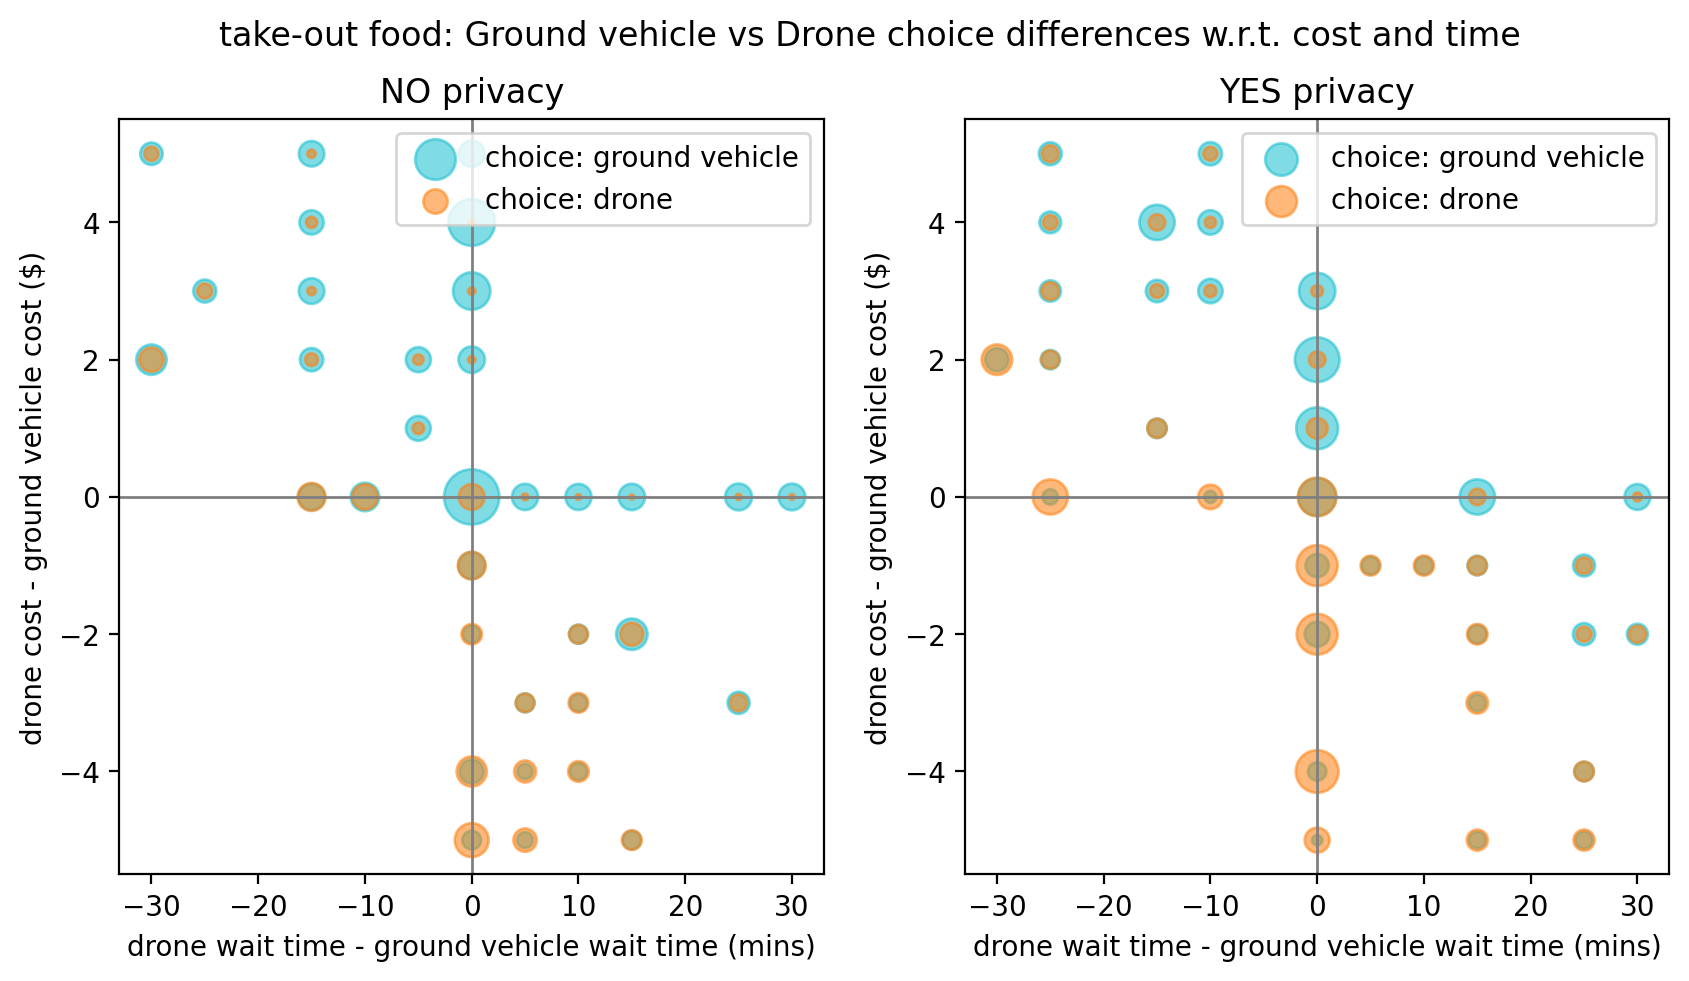

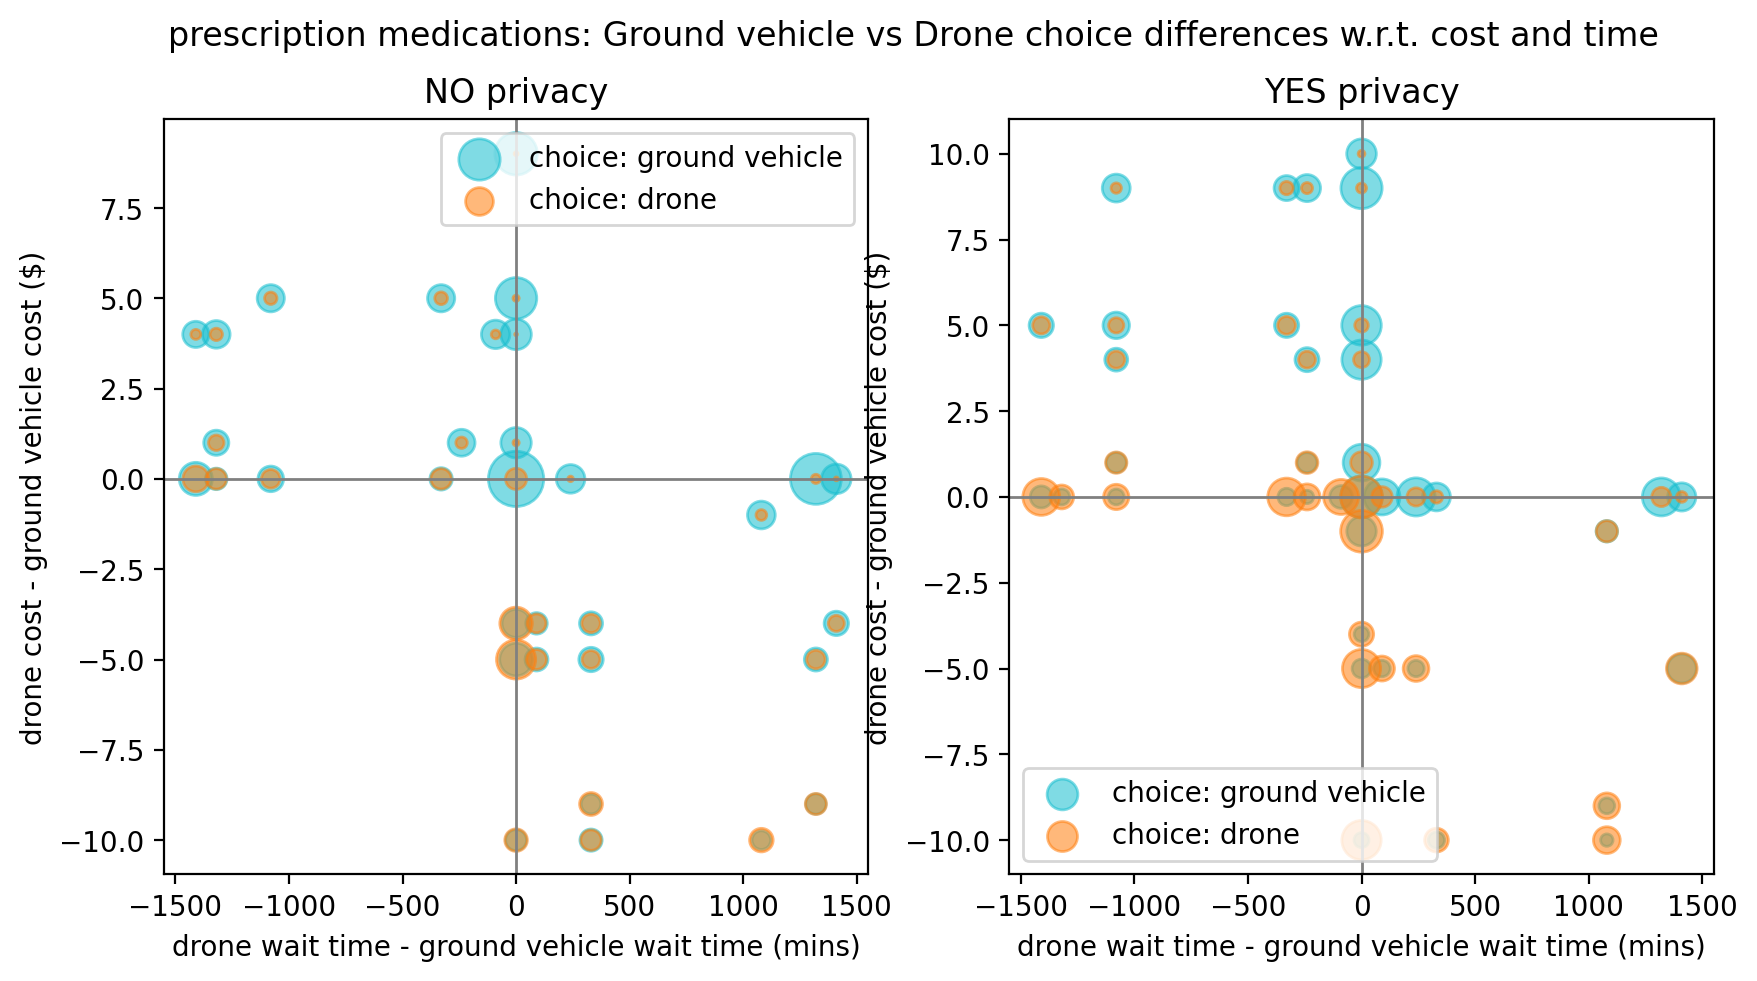

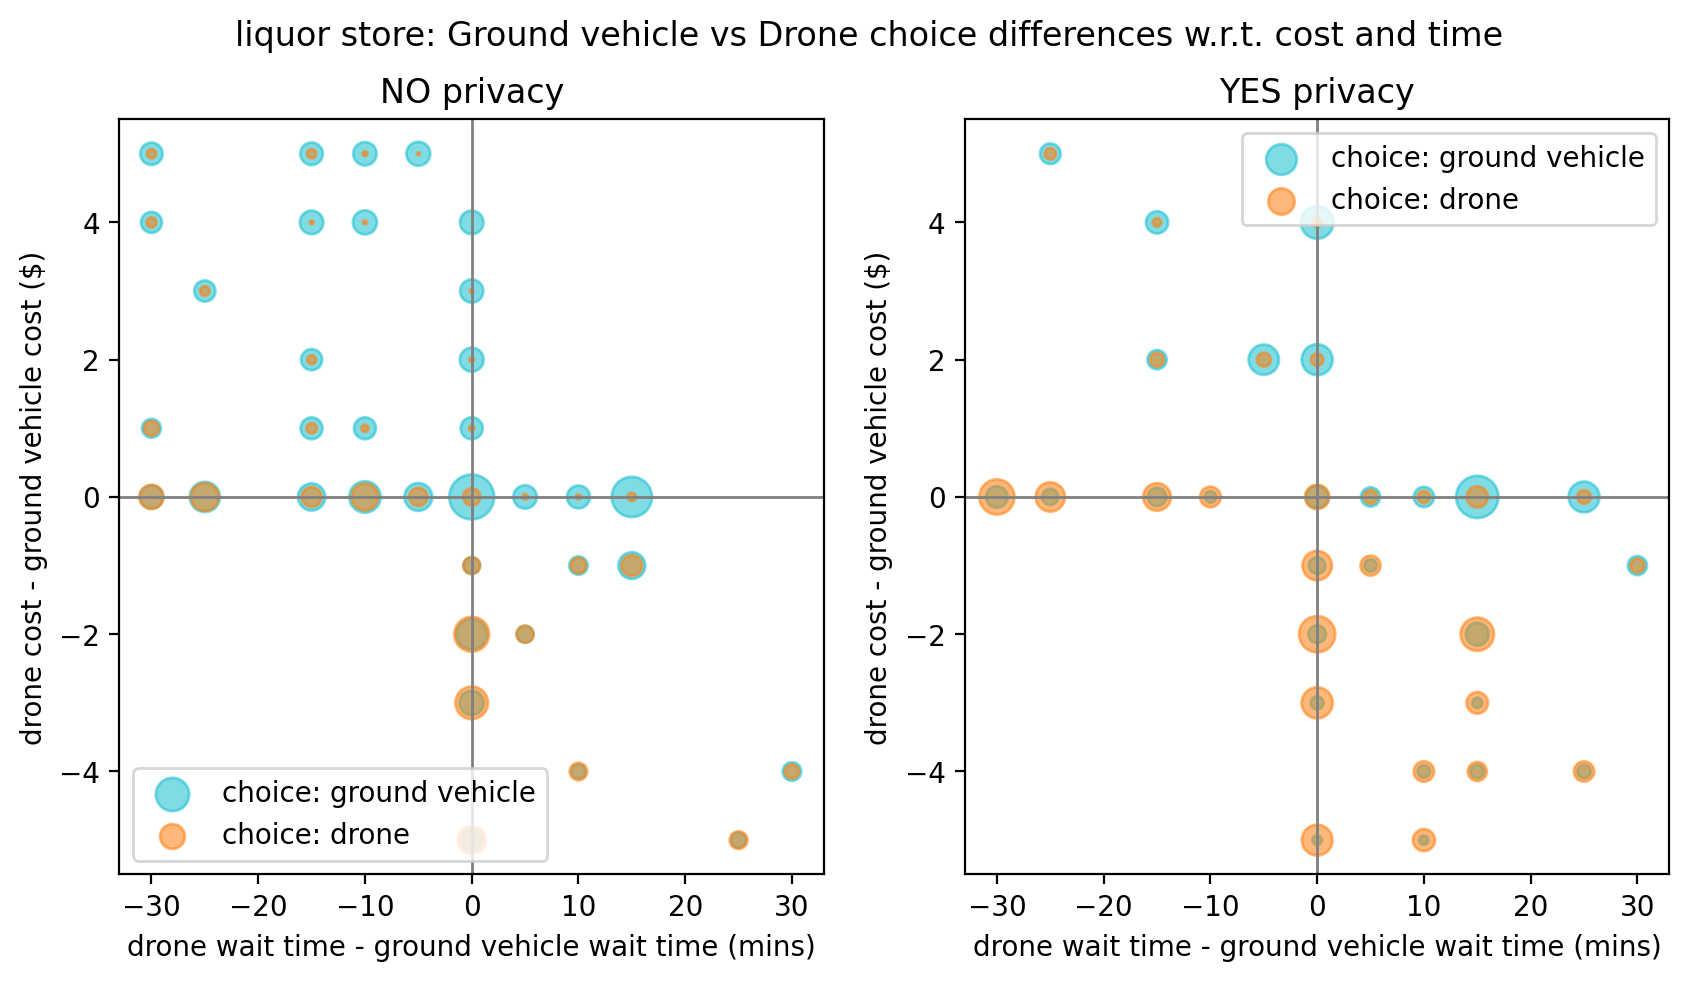

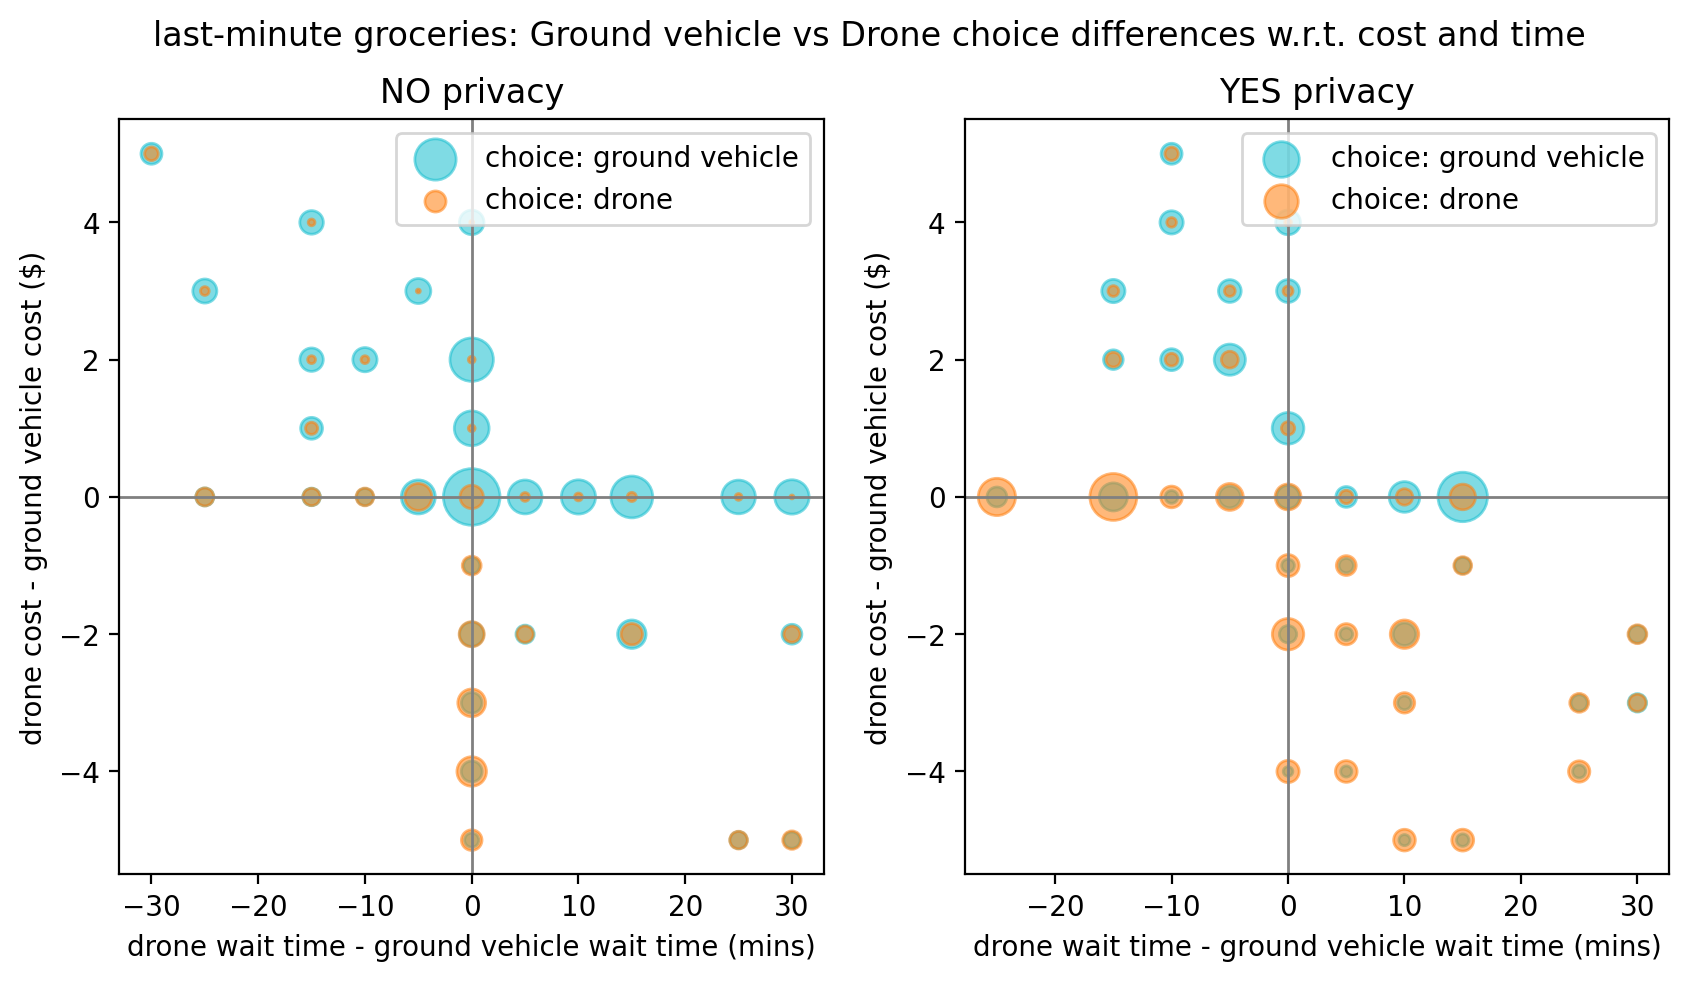

In [4]:
for v, vendor_type in enumerate(VENDOR_TYPES):
    vdf = choices_df[choices_df['v']==v]
    plot_points_tradeoff_by_size(vdf, vendor_type[0])

## Choices by cost difference

Make a choice set limited to choices where time is the same across mode types.

This takes time out of the equation.

Also:
Limit to choices where either neither or both of the options are free. This is because we find that whether an option is free has an additional non-linear impact on choice.

In [5]:
cost_diff_choices_df = choices_df[(choices_df['g_time']==choices_df['d_time'])]
print('%0.2f = %s/%s total choices with drone time = ground vehicle time' % (
    len(cost_diff_choices_df)/len(choices_df), len(cost_diff_choices_df), len(choices_df)))

cost_diff_choices_df = cost_diff_choices_df[
    (cost_diff_choices_df['d_free']==cost_diff_choices_df['g_free'])
]

print('%0.2f = %s/%s total choices with drone time = ground vehicle time & either both or neither option is free' % (
    len(cost_diff_choices_df)/len(choices_df), len(cost_diff_choices_df), len(choices_df)))

# also, limit to columns we want to inspect for cost differences
cost_diff_choices_df = cost_diff_choices_df[['choice','dp','d_cost - g_cost','v','v_type']]
cost_diff_choices_df.head()

0.36 = 12995/36297 total choices with drone time = ground vehicle time
0.22 = 8051/36297 total choices with drone time = ground vehicle time & either both or neither option is free


,choice,dp,d_cost - g_cost,v,v_type
10,1,0,-4,0,take-out food
26,1,1,-2,0,take-out food
28,0,1,4,2,liquor store
29,1,1,0,0,take-out food
33,0,1,-2,2,liquor store


In [6]:
# how does this differ by vendor type? will there be enough data?
for v, vendor_type in enumerate(VENDOR_TYPES):
    print('v%s: %s' % (v, vendor_type[0]))
    vdf = choices_df[choices_df['v']==v]
    v_cost_diff_choices_df = cost_diff_choices_df[cost_diff_choices_df['v']==v]
    print('%0.2f = %s/%s choices with drone time = ground vehicle time' % (
    len(v_cost_diff_choices_df)/len(vdf), len(v_cost_diff_choices_df), len(vdf)))

v0: take-out food
0.25 = 2396/9528 choices with drone time = ground vehicle time
v1: prescription medications
0.23 = 2651/11481 choices with drone time = ground vehicle time
v2: liquor store
0.19 = 1378/7269 choices with drone time = ground vehicle time
v3: last-minute groceries
0.20 = 1626/8019 choices with drone time = ground vehicle time


## Plots by cost difference

To help us understand the trade-offs between price and privacy, and how cost differences impact choice probability.

In the following plots:
- data limited to choice where drone time = ground vehicle time
- choices where only one option is free are excluded
- \% choice probability:  percent of times option was chosen when presented

Plots:
- x-axis: $ price difference (drone cost - ground vehicle cost)
- y-axis: \% choice probability

Data points, connected by lines for:
- NO privacy for drone choices:
    - ground vehicle in choice with NO drone privacy
    - drone in choice with NO drone privacy
- YES privacy for drone choices:
    - ground vehicle in choice with drone privacy
    - drone in choice with drone privacy

Investigate:
- at what price difference (point on x-axis) do lines representing avg choice probability for drone vs ground vehicle cross? Look at choice situations for yes privacy vs no privacy separately.
- what is the distance on the x-axis (i.e. price difference) between where the drone and ground vehicle choice probability lines cross for YES privacy vs NO privacy? (What does this say about the value of privacy?)
- at x=0=price difference: what is the distance on the y-axis (\% choice probability) for drone for yes vs no privacy? i.e. how much does privacy increase the \% of drone choices, on average, when cost and time are the same for drone and ground vehicle delivery?

In [7]:
# only include columns we want to plot
print('cost differences')
print(sorted(cost_diff_choices_df['d_cost - g_cost'].unique()))
print('we exclude $9 from the plot since there is no -$9 << this is due to random selection of 100 choices per vendor type from all possibilities')
cost_diff_choices_df = cost_diff_choices_df[cost_diff_choices_df['d_cost - g_cost'] < 9]
print('cost differences: %s total choices' % len(cost_diff_choices_df))
print(sorted(cost_diff_choices_df['d_cost - g_cost'].unique()))
cost_diff_choices_df.head()

cost differences
[-5, -4, -2, 0, 2, 4, 5, 9]
we exclude $9 from the plot since there is no -$9 << this is due to random selection of 100 choices per vendor type from all possibilities
cost differences: 7582 total choices
[-5, -4, -2, 0, 2, 4, 5]


,choice,dp,d_cost - g_cost,v,v_type
10,1,0,-4,0,take-out food
26,1,1,-2,0,take-out food
28,0,1,4,2,liquor store
29,1,1,0,0,take-out food
33,0,1,-2,2,liquor store


In [8]:
# how does this differ by vendor type? will there be enough data?
for v, vendor_type in enumerate(VENDOR_TYPES):
    print('v%s: %s' % (v, vendor_type[0]))
    vdf = choices_df[choices_df['v']==v]
    v_cost_diff_choices_df = cost_diff_choices_df[cost_diff_choices_df['v']==v]
    print('%0.2f = %s/%s choices with drone time = ground vehicle time' % (
    len(v_cost_diff_choices_df)/len(vdf), len(v_cost_diff_choices_df), len(vdf)))

v0: take-out food
0.25 = 2396/9528 choices with drone time = ground vehicle time
v1: prescription medications
0.19 = 2182/11481 choices with drone time = ground vehicle time
v2: liquor store
0.19 = 1378/7269 choices with drone time = ground vehicle time
v3: last-minute groceries
0.20 = 1626/8019 choices with drone time = ground vehicle time


In [9]:
c_drone = 'blue'
c_ground = 'black'


def plot_choice_by_cost_diff(plot_df, ax, groupby='d_cost - g_cost'):
    """
    Groups choices by cost difference and whether or not drnoe privacy was in choice set.
    Plots choice probabilities by cost difference and returns grouped dataframe.
    """
    no_dp_df = (
        plot_df[plot_df['dp']==0]
        .groupby(groupby)['choice']
        .agg(['count','mean'])
        .rename(columns={'mean':'% drone choice'})
    )
    no_dp_df['% ground vehicle choice'] = 1 - no_dp_df['% drone choice']
    yes_dp_df = (
        plot_df[plot_df['dp']==1]
        .groupby(groupby)['choice']
        .agg(['count','mean'])
        .rename(columns={'mean':'% drone choice'})
    )
    yes_dp_df['% ground vehicle choice'] = 1 - yes_dp_df['% drone choice']
    # merge them
    all_df = yes_dp_df.merge(
        no_dp_df, 
        how='outer',
        left_index=True, right_index=True,
        suffixes=[': YES privacy', ': NO privacy']
    )
    # yes privacy
    ax.plot(
        all_df.index, 
        100*all_df['% drone choice: YES privacy'],
        '--s',
        color=c_drone,
        label='drone: choice with drone privacy',
    )
    ax.plot(
        all_df.index, 
        100*all_df['% ground vehicle choice: YES privacy'],
        '--s',
        color=c_ground,
        label='ground vehicle: choice with drone privacy',
    )
    # no privacy
    ax.plot(
        all_df.index, 
        100*all_df['% drone choice: NO privacy'],
        '-o',
        color=c_drone,
        label='drone: choice with NO drone privacy',
    )
    ax.plot(
        all_df.index, 
        100*all_df['% ground vehicle choice: NO privacy'],
        '-o',
        color=c_ground,
        label='ground vehicle: choice with NO drone privacy',
    )
    ax.set_xticks(list(range(-4, 5, 2)))
    ax.set_ylim(0,100)

    ax.axvline(0, color='black', alpha=0.3)
    return all_df
    

Not simplified values. With tables and plots by vendor type.

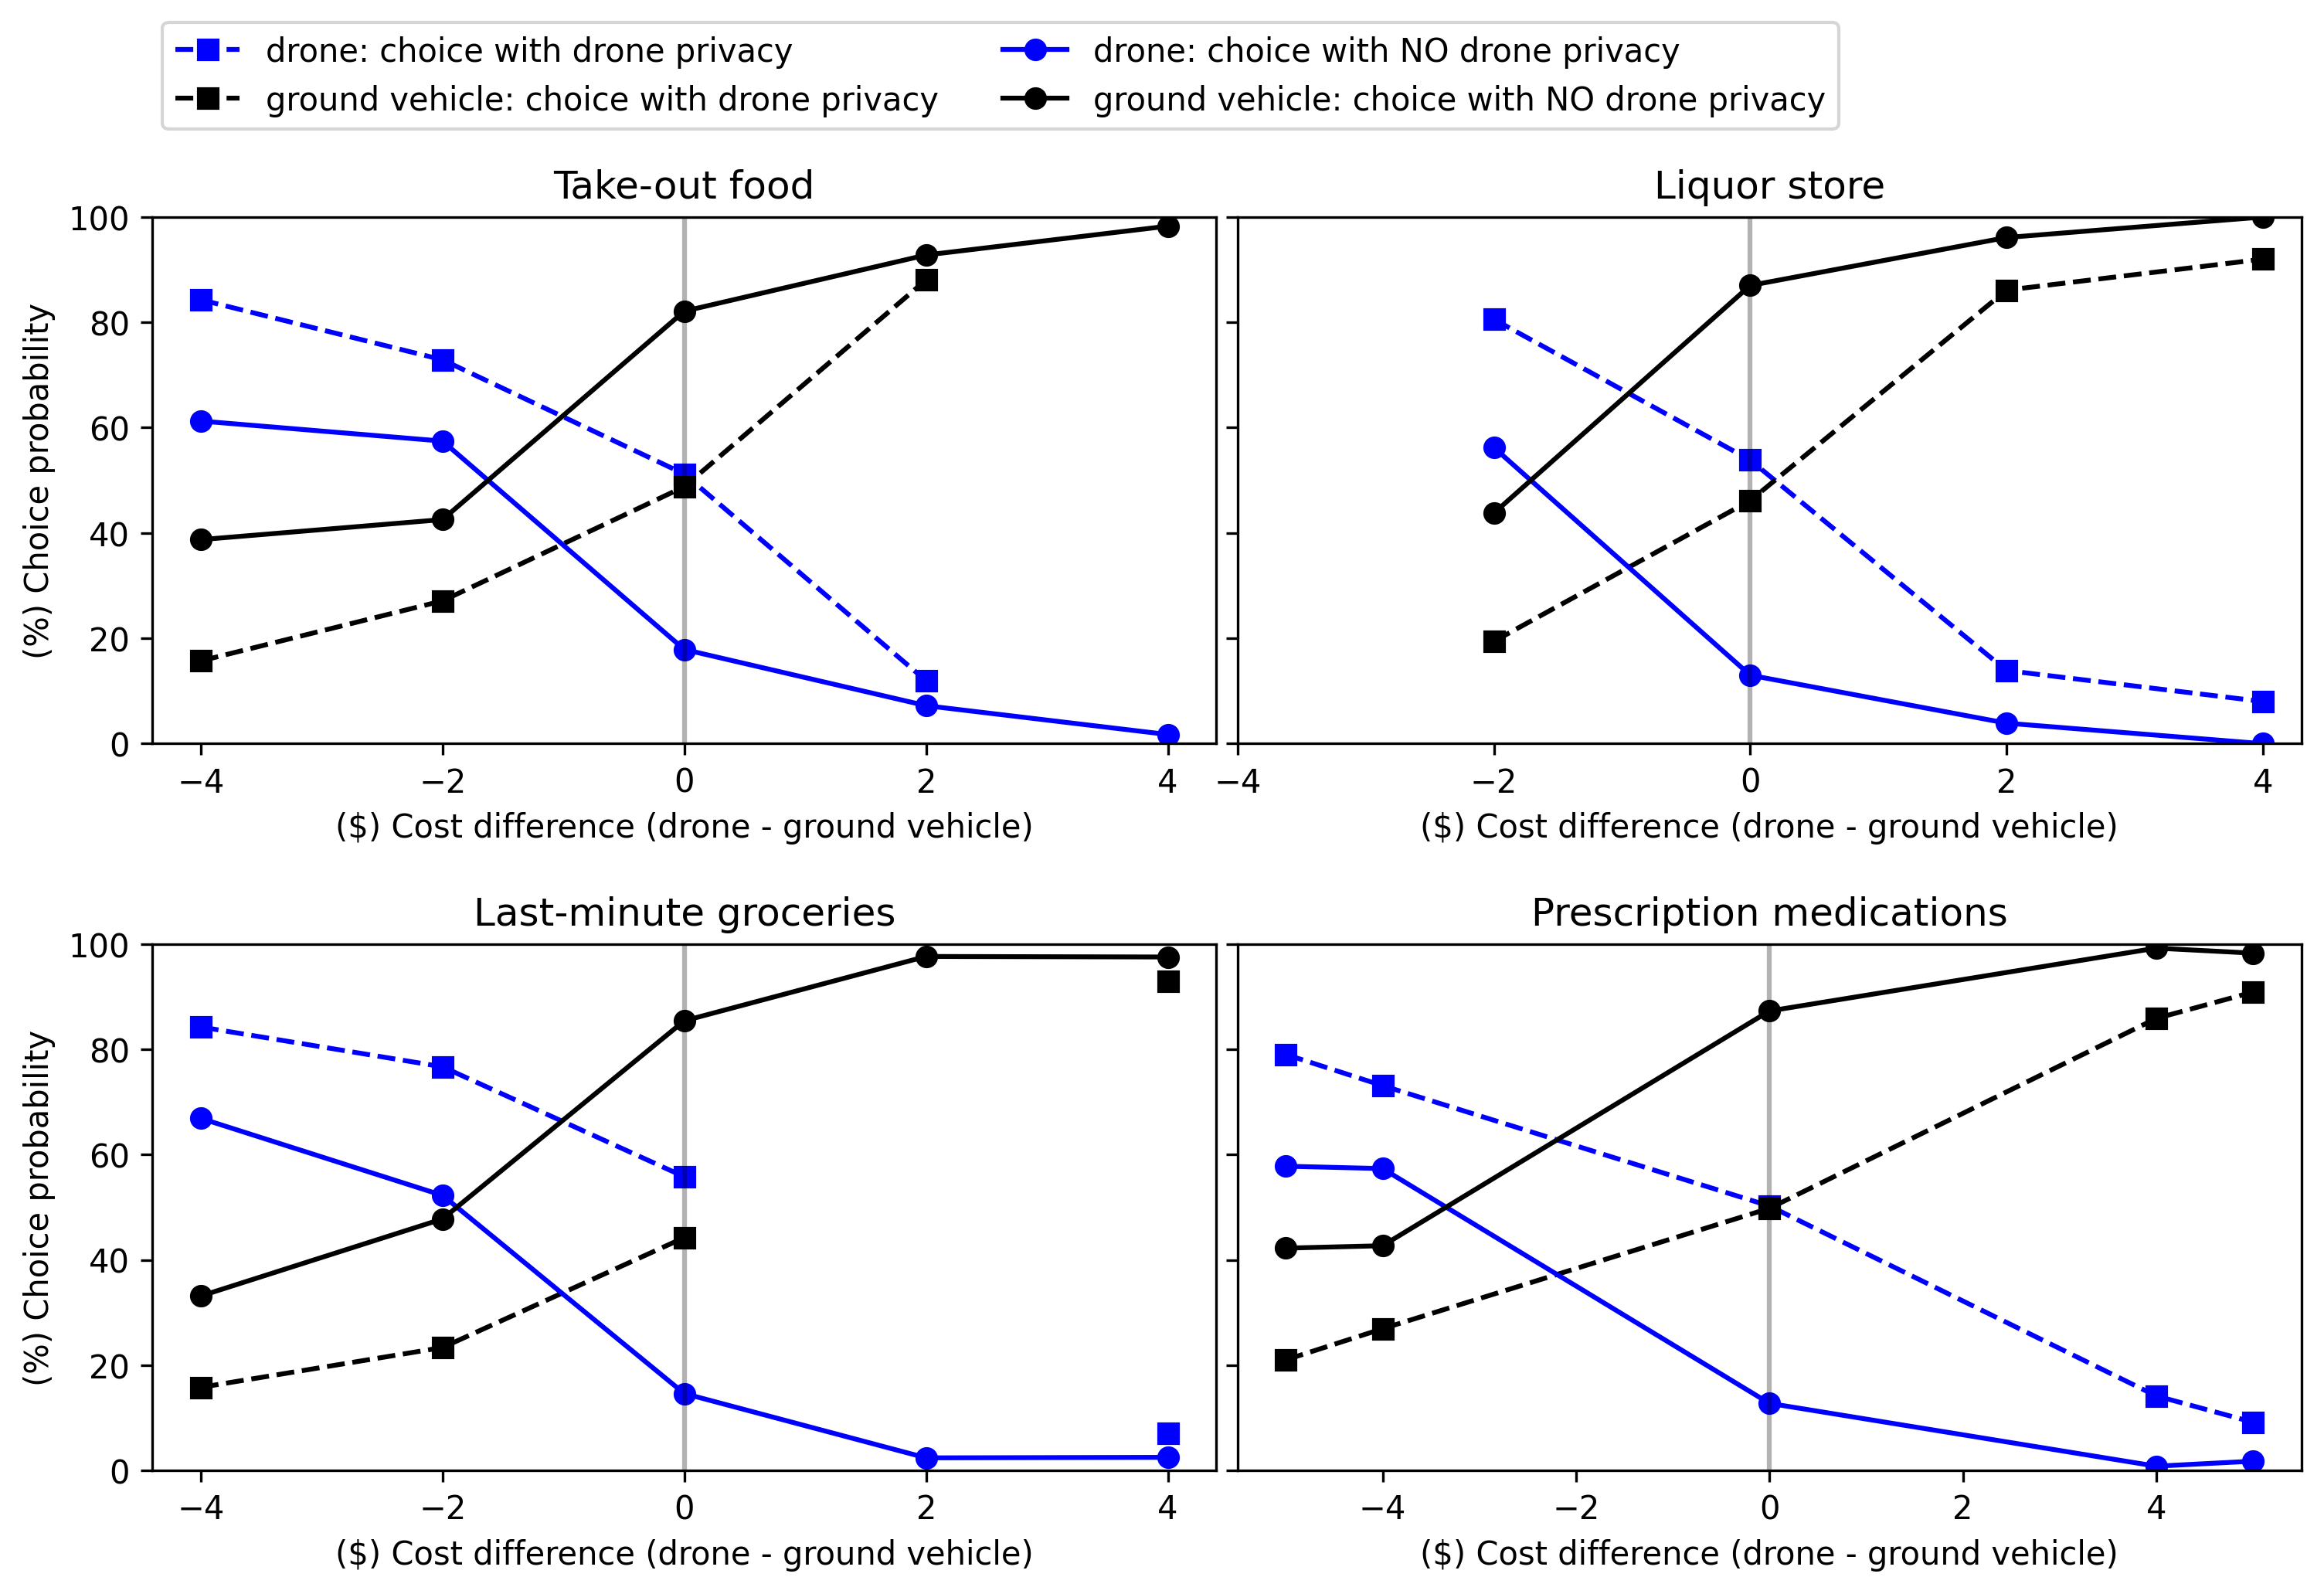

In [82]:
# fig, axes = plt.subplots(1,4, figsize=(18,2.5),dpi=200,sharey=True)
fig, axes = plt.subplots(2,2, figsize=(10,6),dpi=300,sharey=True)
plt.tight_layout()
plt.subplots_adjust(wspace=0.02, hspace=0.38)
plots_order_vs = [0,2,3,1] # determines plot order
plot_dfs = []
for i, v in enumerate(plots_order_vs):
    ax = axes.flat[i]
    v_type = VENDOR_TYPES[v][0]
    ax.set_xlabel('($) Cost difference (drone - ground vehicle)')
    if i%2==0:
        ax.set_ylabel('(%) Choice probability')
    plot_df = plot_choice_by_cost_diff(
        cost_diff_choices_df[cost_diff_choices_df['v']==v],
        ax,
    ).round(3)
    ax.set_title(v_type.capitalize())
    if v==0:
        ax.legend(ncol=2, bbox_to_anchor=(1.6, 1.4))
    plot_dfs = plot_dfs + [plot_df]

Print the data used to make those plots

In [84]:
for i, v in enumerate(plots_order_vs):
    v_type = VENDOR_TYPES[v][0]
    print('v%s: %s' % (v, v_type))
    p_df = plot_dfs[i]
    display_df = p_df.fillna(0).astype({
        'count: YES privacy':'int',
        'count: NO privacy':'int'
    }).style.format({
        '% drone choice: YES privacy': '{:,.1%}'.format,
        '% ground vehicle choice: YES privacy': '{:,.1%}'.format,
        '% drone choice: NO privacy': '{:,.1%}'.format,
        '% ground vehicle choice: NO privacy': '{:,.1%}'.format,
    })
    display(display_df)

v0: take-out food


,count: YES privacy,% drone choice: YES privacy,% ground vehicle choice: YES privacy,count: NO privacy,% drone choice: NO privacy,% ground vehicle choice: NO privacy
d_cost - g_cost,,,,,,
-4,280,84.3%,15.7%,191,61.3%,38.7%
-2,295,72.9%,27.1%,94,57.4%,42.6%
0,377,51.2%,48.8%,481,17.9%,82.1%
2,293,11.9%,88.1%,97,7.2%,92.8%
4,0,0.0%,0.0%,288,1.7%,98.3%


v2: liquor store


,count: YES privacy,% drone choice: YES privacy,% ground vehicle choice: YES privacy,count: NO privacy,% drone choice: NO privacy,% ground vehicle choice: NO privacy
d_cost - g_cost,,,,,,
-2,211,80.6%,19.4%,281,56.2%,43.8%
0,143,53.8%,46.2%,300,13.0%,87.0%
2,144,13.9%,86.1%,77,3.9%,96.1%
4,150,8.0%,92.0%,72,0.0%,100.0%


v3: last-minute groceries


,count: YES privacy,% drone choice: YES privacy,% ground vehicle choice: YES privacy,count: NO privacy,% drone choice: NO privacy,% ground vehicle choice: NO privacy
d_cost - g_cost,,,,,,
-4,76,84.2%,15.8%,169,66.9%,33.1%
-2,167,76.6%,23.4%,157,52.2%,47.8%
0,156,55.8%,44.2%,486,14.6%,85.4%
2,0,0.0%,0.0%,250,2.4%,97.6%
4,85,7.1%,92.9%,80,2.5%,97.5%


v1: prescription medications


,count: YES privacy,% drone choice: YES privacy,% ground vehicle choice: YES privacy,count: NO privacy,% drone choice: NO privacy,% ground vehicle choice: NO privacy
d_cost - g_cost,,,,,,
-5,119,79.0%,21.0%,225,57.8%,42.2%
-4,104,73.1%,26.9%,239,57.3%,42.7%
0,452,50.2%,49.8%,455,12.7%,87.3%
4,233,14.2%,85.8%,122,0.8%,99.2%
5,120,9.2%,90.8%,113,1.8%,98.2%


Print the data used to make the plots in Latex

In [86]:
# for i, v in enumerate(plots_order_vs):
#     p_df = plot_dfs[i]
#     v_type = VENDOR_TYPES[v][0]
#     print('v%s: %s\n' % (v, v_type))
#     display_df = p_df.fillna(0).astype({
#         'count: YES privacy':'int',
#         'count: NO privacy':'int'
#     }).style.format({
#         '% drone choice: YES privacy': '{:,.1%}'.format,
#         '% ground vehicle choice: YES privacy': '{:,.1%}'.format,
#         '% drone choice: NO privacy': '{:,.1%}'.format,
#         '% ground vehicle choice: NO privacy': '{:,.1%}'.format,
#     })
#     print(display_df.to_latex())

Make a simpler plot that combines values to just be:
- drone costs less
- 0
- ground vehicle costs less

,count: YES privacy,% drone choice: YES privacy,% ground vehicle choice: YES privacy,count: NO privacy,% drone choice: NO privacy,% ground vehicle choice: NO privacy
dc vs gc,,,,,,
-1,575,0.784,0.216,285,0.600,0.400
0,377,0.512,0.488,481,0.179,0.821
1,293,0.119,0.881,385,0.031,0.969


,count: YES privacy,% drone choice: YES privacy,% ground vehicle choice: YES privacy,count: NO privacy,% drone choice: NO privacy,% ground vehicle choice: NO privacy
dc vs gc,,,,,,
-1,211,0.806,0.194,281,0.562,0.438
0,143,0.538,0.462,300,0.130,0.870
1,294,0.109,0.891,149,0.020,0.980


,count: YES privacy,% drone choice: YES privacy,% ground vehicle choice: YES privacy,count: NO privacy,% drone choice: NO privacy,% ground vehicle choice: NO privacy
dc vs gc,,,,,,
-1,243,0.790,0.210,326,0.598,0.402
0,156,0.558,0.442,486,0.146,0.854
1,85,0.071,0.929,330,0.024,0.976


,count: YES privacy,% drone choice: YES privacy,% ground vehicle choice: YES privacy,count: NO privacy,% drone choice: NO privacy,% ground vehicle choice: NO privacy
dc vs gc,,,,,,
-1,223,0.762,0.238,464,0.575,0.425
0,452,0.502,0.498,455,0.127,0.873
1,353,0.125,0.875,235,0.013,0.987


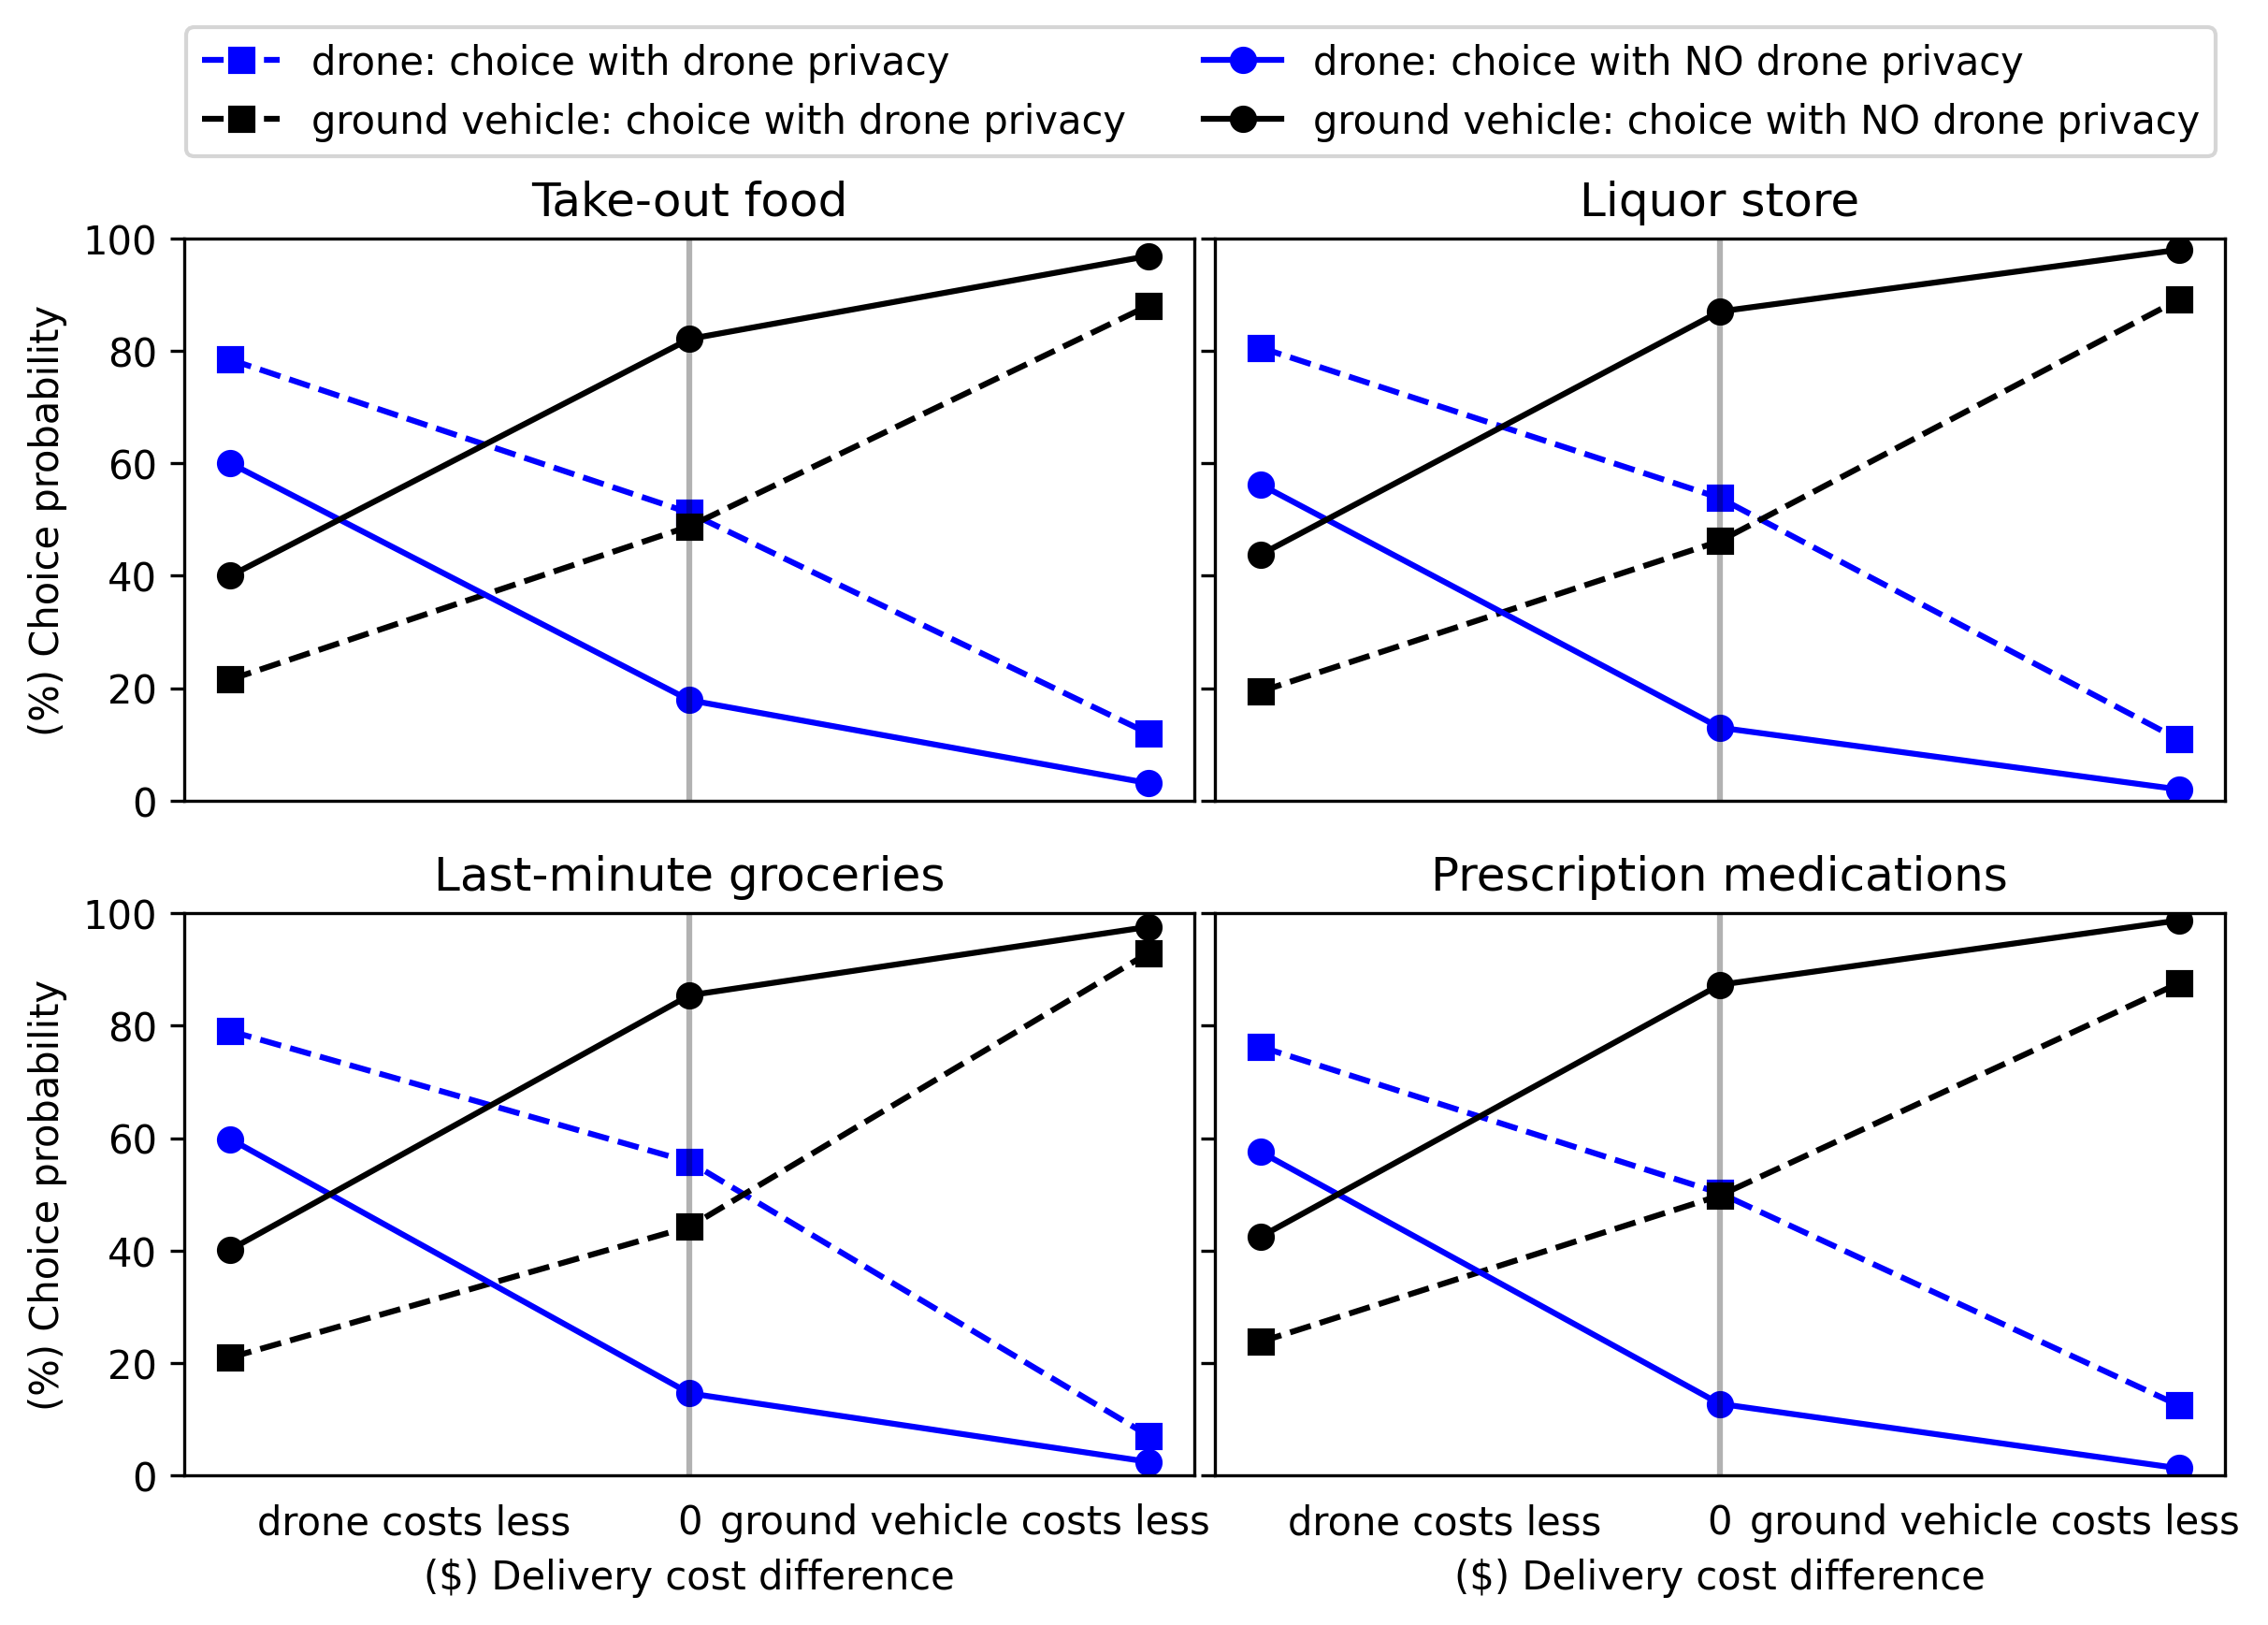

In [87]:
fig, axes = plt.subplots(2,2, figsize=(8,5),dpi=300,sharey=True,sharex=True)
plt.tight_layout()
plt.subplots_adjust(wspace=0.02, hspace=0.2)
plots_order_vs = [0,2,3,1] # determines plot order
for i, v in enumerate(plots_order_vs):
    ax = axes.flat[i]
    v_type = VENDOR_TYPES[v][0]
    if i%2==0:
        ax.set_ylabel('(%) Choice probability')

    vdf = cost_diff_choices_df[cost_diff_choices_df['v']==v].copy()
    vdf['dc vs gc'] = vdf['d_cost - g_cost'].apply(lambda c: 0 if c == 0 else (-1 if c<0 else 1))

    plot_df = plot_choice_by_cost_diff(vdf, ax, groupby='dc vs gc').round(3)
    ax.set_xlim([-1.1,1.1])
    #if i < 2:
    ax.xaxis.set_ticks_position('none') 
    if i > 1:
        ax.set_xlabel('($) Delivery cost difference')
    ax.set_xticks([-0.6,0,0.6])
    ax.set_xticklabels(['drone costs less','0','ground vehicle costs less'])
    ax.set_title(v_type.capitalize())
    if v==0:
        ax.legend(ncol=2, bbox_to_anchor=(2.03, 1.41))
    display(plot_df)

,count: YES privacy,% drone choice: YES privacy,% ground vehicle choice: YES privacy,count: NO privacy,% drone choice: NO privacy,% ground vehicle choice: NO privacy
d_cost - g_cost,,,,,,
-5,119,0.789916,0.210084,225,0.577778,0.422222
-4,460,0.817391,0.182609,599,0.612688,0.387312
-2,673,0.762259,0.237741,532,0.552632,0.447368
0,1128,0.517730,0.482270,1722,0.147503,0.852497
2,437,0.125858,0.874142,424,0.037736,0.962264
4,468,0.108974,0.891026,562,0.014235,0.985765
5,120,0.091667,0.908333,113,0.017699,0.982301


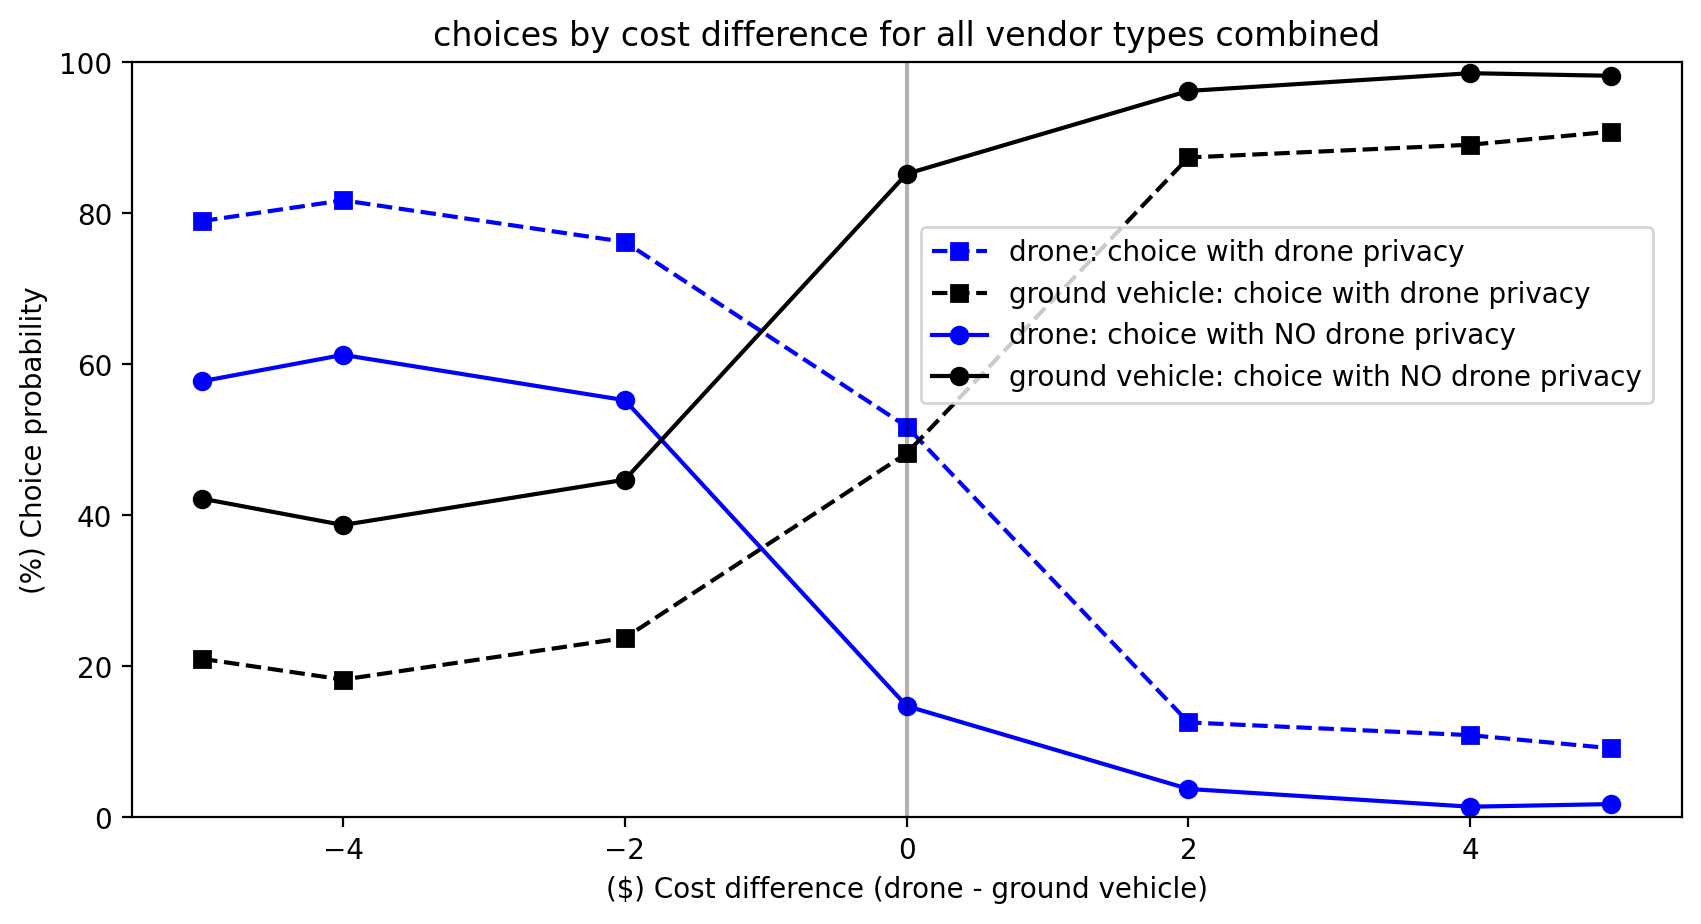

In [88]:
fig,ax = plt.subplots(1,1, figsize=(10,5), dpi=200)
df = plot_choice_by_cost_diff(cost_diff_choices_df, ax)
ax.legend(bbox_to_anchor=(0.5, 0.8))
ax.set_xlabel('($) Cost difference (drone - ground vehicle)')
ax.set_ylabel('(%) Choice probability') 
ax.set_title('choices by cost difference for all vendor types combined')
df

The following plot restricts to vendors v0,v2,v3 because they share the same attribute values.

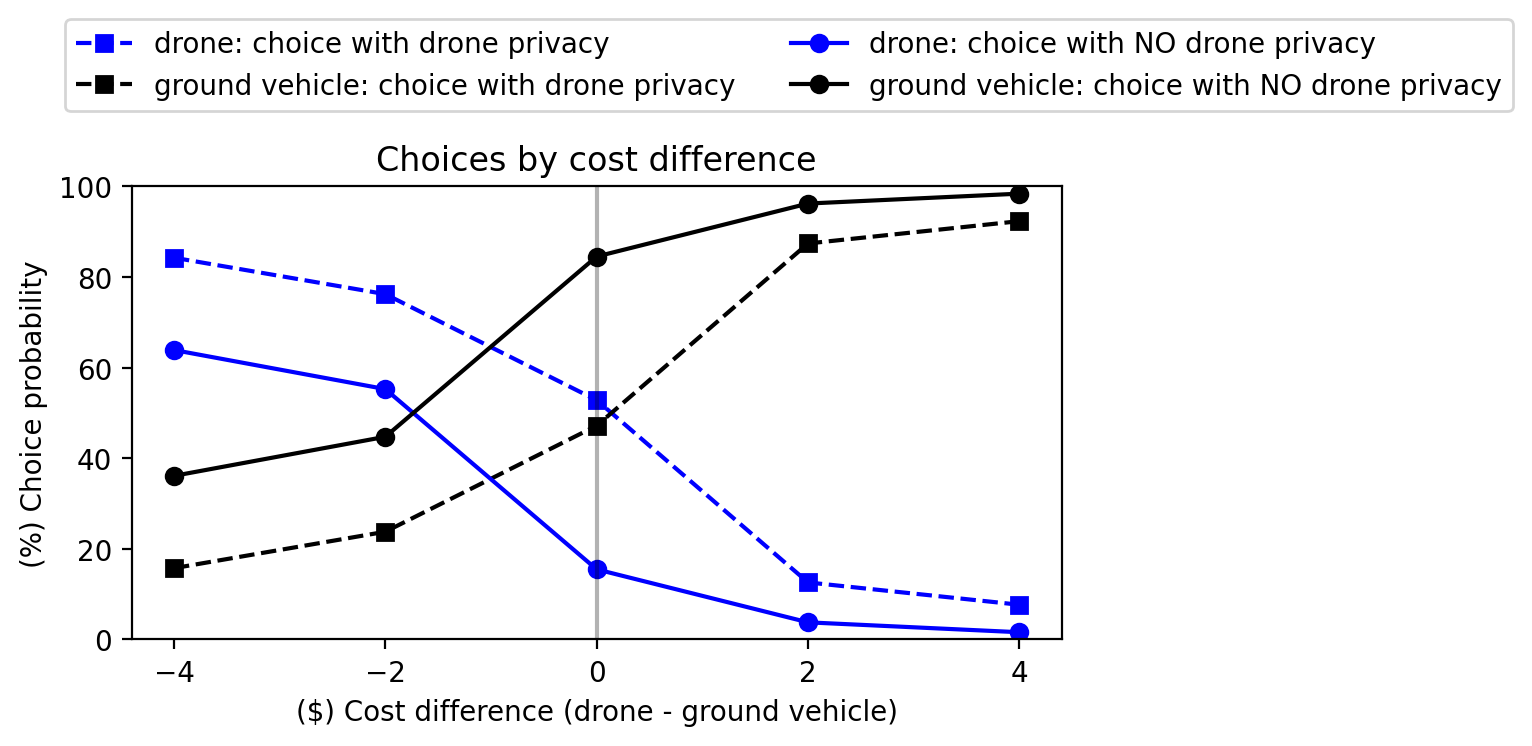

,count: YES privacy,% drone choice: YES privacy,% ground vehicle choice: YES privacy,count: NO privacy,% drone choice: NO privacy,% ground vehicle choice: NO privacy
d_cost - g_cost,,,,,,
-4,356,0.842697,0.157303,360,0.638889,0.361111
-2,673,0.762259,0.237741,532,0.552632,0.447368
0,676,0.528107,0.471893,1267,0.154696,0.845304
2,437,0.125858,0.874142,424,0.037736,0.962264
4,235,0.076596,0.923404,440,0.015909,0.984091


In [89]:
fig,ax = plt.subplots(1,1, figsize=(6,3), dpi=200)
df = plot_choice_by_cost_diff(
    cost_diff_choices_df[cost_diff_choices_df['v'].isin([0,2,3])], ax
)
# ax.legend(bbox_to_anchor=(0.5, 0.8))
ax.legend(ncol=2, bbox_to_anchor=(1.5, 1.4))
ax.set_xlabel('($) Cost difference (drone - ground vehicle)')
ax.set_ylabel('(%) Choice probability') 
ax.set_title('Choices by cost difference')
plt.show()
df

## Choice by time difference

Here we do similarly as we did for cost difference: 

Make a choice set limited to choices where *cost* is the same across mode types.

This takes cost out of the equation.

In [90]:
time_diff_choices_df = choices_df[(choices_df['gc']==choices_df['dc'])]
print('%0.2f = %s/%s total choices with drone time = ground vehicle time' % (
    len(time_diff_choices_df)/len(choices_df), len(time_diff_choices_df), len(choices_df)))

# also, limit to columns we want to inspect for cost differences
time_diff_choices_df = time_diff_choices_df[['choice','dp','d_time - g_time', 'dt','gt','v','v_type']]
# time_diff_choices_df.head()

0.35 = 12643/36297 total choices with drone time = ground vehicle time


In [91]:
# how does this differ by vendor type? will there be enough data?
for v, vendor_type in enumerate(VENDOR_TYPES):
    print('v%s: %s' % (v, vendor_type[0]))
    vdf = choices_df[choices_df['v']==v]
    v_time_diff_choices_df = time_diff_choices_df[time_diff_choices_df['v']==v]
    print('%0.2f = %s/%s choices with drone cost = ground vehicle cost' % (
    len(v_time_diff_choices_df)/len(vdf), len(v_time_diff_choices_df), len(vdf)))

v0: take-out food
0.24 = 2290/9528 choices with drone cost = ground vehicle cost
v1: prescription medications
0.35 = 4020/11481 choices with drone cost = ground vehicle cost
v2: liquor store
0.39 = 2848/7269 choices with drone cost = ground vehicle cost
v3: last-minute groceries
0.43 = 3485/8019 choices with drone cost = ground vehicle cost


In [92]:
# there are gaps if we include last-minute groceries
print(sorted(time_diff_choices_df['d_time - g_time'].unique()))

[-1410, -1320, -1080, -330, -240, -90, -30, -25, -15, -10, -5, 0, 5, 10, 15, 25, 30, 90, 240, 330, 1320, 1410]


## Plots by time difference

To help us understand the trade-offs between time and privacy, and how time differences impact choice probability.

In the following plots:

- data limited to choice where drone cost = ground vehicle cost
- % choice probability: percent of times option was chosen when presented
Plots:

- x-axis: time difference (drone time - ground vehicle time)
- y-axis: % choice probability

Data points, connected by lines for:

Investigate:

- at what time difference (point on x-axis) do lines representing avg choice probability for drone vs ground vehicle cross? Look at choice situations for yes privacy vs no privacy separately.
- what is the distance on the x-axis (i.e. time difference) between where the drone and ground vehicle choice probability lines cross for YES privacy vs NO privacy? (What does this say about the value of privacy?)
- at x=0=time difference: what is the distance on the y-axis (% choice probability) for drone for YES vs NO privacy? i.e. how much does privacy increase the % of drone choices, on average, when cost and time are the same for drone and ground vehicle delivery?
    - this should be the same for the plots by cost difference plots

In [93]:
def plot_choice_by_time_diff(plot_df, ax, groupby='d_time - g_time'):
    """
    Groups choices by time difference and whether or not drone privacy was in choice set.
    Plots choice probabilities by time difference and returns grouped dataframe.
    """
    no_dp_df = (
        plot_df[plot_df['dp']==0]
        .groupby(groupby)['choice']
        .agg(['count','mean'])
        .rename(columns={'mean':'% drone choice'})
    )
    no_dp_df['% ground vehicle choice'] = 1 - no_dp_df['% drone choice']
    yes_dp_df = (
        plot_df[plot_df['dp']==1]
        .groupby(groupby)['choice']
        .agg(['count','mean'])
        .rename(columns={'mean':'% drone choice'})
    )
    yes_dp_df['% ground vehicle choice'] = 1 - yes_dp_df['% drone choice']
    # merge them
    all_df = yes_dp_df.merge(
        no_dp_df, 
        how='outer',
        left_index=True, right_index=True,
        suffixes=[': YES privacy', ': NO privacy']
    )
    # yes privacy
    ax.plot(
        all_df.index, 
        100*all_df['% drone choice: YES privacy'],
        '--s',
        color=c_drone,
        label='drone: choice with drone privacy',
    )
    ax.plot(
        all_df.index, 
        100*all_df['% ground vehicle choice: YES privacy'],
        '--s',
        color=c_ground,
        label='ground vehicle: choice with drone privacy',
    )
    # no privacy
    ax.plot(
        all_df.index, 
        100*all_df['% drone choice: NO privacy'],
        '-o',
        color=c_drone,
        label='drone: choice with NO drone privacy',
    )
    ax.plot(
        all_df.index, 
        100*all_df['% ground vehicle choice: NO privacy'],
        '-o',
        color=c_ground,
        label='ground vehicle: choice with NO drone privacy',
    )
    #ax.set_xticks(list(range(-4, 5, 2)))
    ax.set_ylim(0,100)

    ax.axvline(0, color='black', alpha=0.3)
    return all_df

Make a simpler plot that combines values to just be:
- drone time better
- 0
- drone time worse

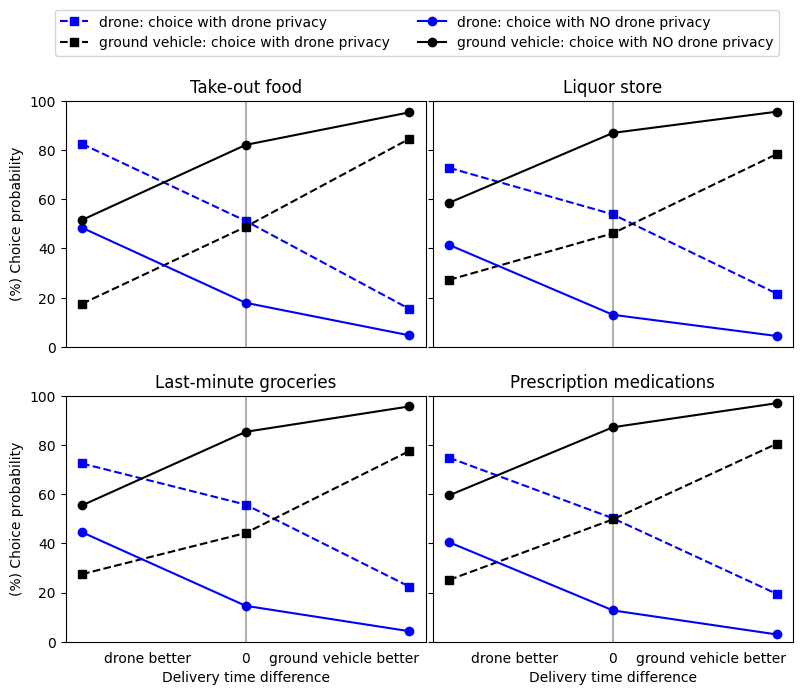

In [94]:
fig, axes = plt.subplots(2,2, figsize=(8,6),dpi=100,sharey=True,sharex=True)
plt.tight_layout()
plt.subplots_adjust(wspace=0.02, hspace=0.2)
plots_order_vs = [0,2,3,1] # determines plot order
for i, v in enumerate(plots_order_vs):
    ax = axes.flat[i]
    v_type = VENDOR_TYPES[v][0]
    if i%2==0:
        ax.set_ylabel('(%) Choice probability')

    vdf = time_diff_choices_df[time_diff_choices_df['v']==v].copy()
    vdf['dt vs gt'] = vdf['d_time - g_time'].apply(lambda t: 0 if t == 0 else (-1 if t<0 else 1))

    plot_df = plot_choice_by_time_diff(vdf, ax, groupby='dt vs gt').round(3)
    ax.set_xlim([-1.1,1.1])
    #if i < 2:
    ax.xaxis.set_ticks_position('none') 
    if i > 1:
        ax.set_xlabel('Delivery time difference')
    ax.set_xticks([-0.6,0,0.6])
    ax.set_xticklabels(['drone better','0','ground vehicle better'])
    ax.set_title(v_type.capitalize())
    if v==0:
        ax.legend(ncol=2, bbox_to_anchor=(2, 1.4))
    #display(plot_df)

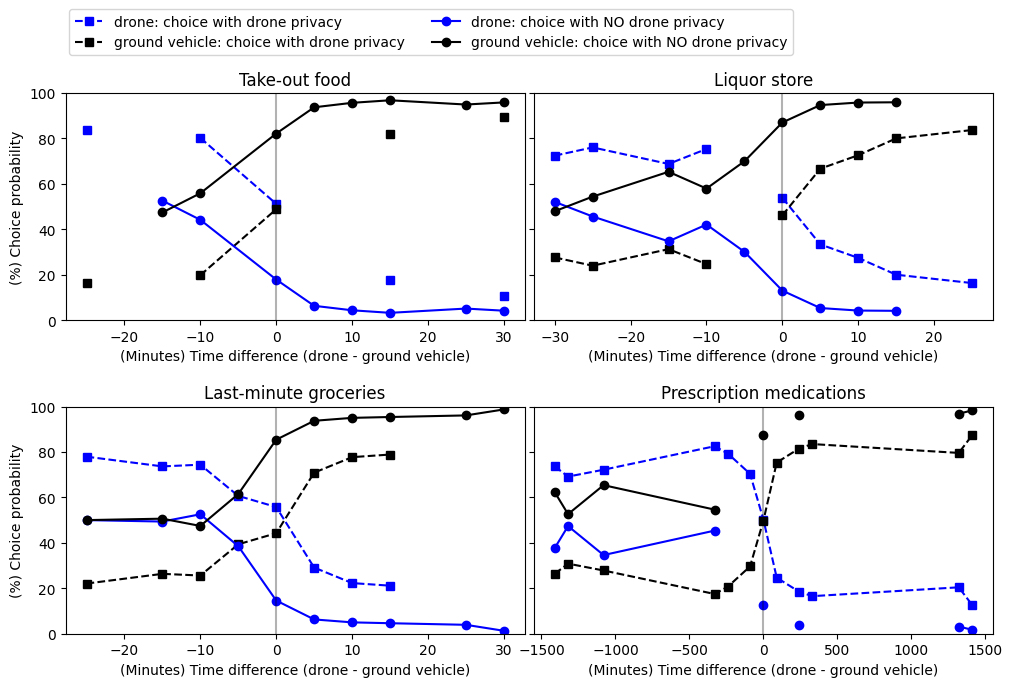

In [95]:
fig, axes = plt.subplots(2,2, figsize=(10,6),dpi=100,sharey=True)
plt.tight_layout()
plt.subplots_adjust(wspace=0.02, hspace=0.38)
plots_order_vs = [0,2,3,1] # determines plot order
t_plot_dfs = []
for i, v in enumerate(plots_order_vs):
    ax = axes.flat[i]
    v_type = VENDOR_TYPES[v][0]
    ax.set_xlabel('(Minutes) Time difference (drone - ground vehicle)')
    if i%2==0:
        ax.set_ylabel('(%) Choice probability')
    plot_df = plot_choice_by_time_diff(
        time_diff_choices_df[time_diff_choices_df['v']==v],
        ax,
    ).round(3)
    ax.set_title(v_type.capitalize())
    if v==0:
        ax.legend(ncol=2, bbox_to_anchor=(1.6, 1.4))
    t_plot_dfs = t_plot_dfs + [plot_df]

Print the data used to make those plots

In [160]:
idx = [-30, -25, -15, -10, -5, 0, 5, 10, 15, 25, 30]
prescription_idx = [-1410, -1320, -1080, -330, -240, -90, 0, 90, 240, 330, 1080, 1320, 1410]

for i, v in enumerate(plots_order_vs):
    v_type = VENDOR_TYPES[v][0]
    print('v%s: %s' % (v, v_type))
    # update the index
    p_df = pd.DataFrame(
        {'d_time - g_time': prescription_idx if v==1 else idx}
    ).merge(
        t_plot_dfs[i].reset_index(), how='outer', on='d_time - g_time'
    ).set_index('d_time - g_time')
    p_df.index = p_df.index.map(lambda i: '%s minutes'%i)
    display_df = p_df.fillna(0).astype({
        'count: YES privacy':'int',
        'count: NO privacy':'int'
    }).style.format({
        '% drone choice: YES privacy': '{:,.1%}'.format,
        '% ground vehicle choice: YES privacy': '{:,.1%}'.format,
        '% drone choice: NO privacy': '{:,.1%}'.format,
        '% ground vehicle choice: NO privacy': '{:,.1%}'.format,
    })
    display(display_df)

v0: take-out food


,count: YES privacy,% drone choice: YES privacy,% ground vehicle choice: YES privacy,count: NO privacy,% drone choice: NO privacy,% ground vehicle choice: NO privacy
d_time - g_time,,,,,,
-30 minutes,0,0.0%,0.0%,0,0.0%,0.0%
-25 minutes,190,83.7%,16.3%,0,0.0%,0.0%
-15 minutes,0,0.0%,0.0%,192,52.6%,47.4%
-10 minutes,96,80.2%,19.8%,188,44.1%,55.9%
-5 minutes,0,0.0%,0.0%,0,0.0%,0.0%
0 minutes,377,51.2%,48.8%,481,17.9%,82.1%
5 minutes,0,0.0%,0.0%,95,6.3%,93.7%
10 minutes,0,0.0%,0.0%,92,4.3%,95.7%
15 minutes,196,17.9%,82.1%,93,3.2%,96.8%


v2: liquor store


,count: YES privacy,% drone choice: YES privacy,% ground vehicle choice: YES privacy,count: NO privacy,% drone choice: NO privacy,% ground vehicle choice: NO privacy
d_time - g_time,,,,,,
-30 minutes,221,72.4%,27.6%,146,52.1%,47.9%
-25 minutes,146,76.0%,24.0%,217,45.6%,54.4%
-15 minutes,144,68.8%,31.2%,147,34.7%,65.3%
-10 minutes,73,75.3%,24.7%,221,42.1%,57.9%
-5 minutes,0,0.0%,0.0%,143,30.1%,69.9%
0 minutes,143,53.8%,46.2%,300,13.0%,87.0%
5 minutes,72,33.3%,66.7%,75,5.3%,94.7%
10 minutes,73,27.4%,72.6%,71,4.2%,95.8%
15 minutes,290,20.0%,80.0%,219,4.1%,95.9%


v3: last-minute groceries


,count: YES privacy,% drone choice: YES privacy,% ground vehicle choice: YES privacy,count: NO privacy,% drone choice: NO privacy,% ground vehicle choice: NO privacy
d_time - g_time,,,,,,
-30 minutes,0,0.0%,0.0%,0,0.0%,0.0%
-25 minutes,231,77.9%,22.1%,84,50.0%,50.0%
-15 minutes,387,73.6%,26.4%,79,49.4%,50.6%
-10 minutes,82,74.4%,25.6%,78,52.6%,47.4%
-5 minutes,155,60.6%,39.4%,244,38.5%,61.5%
0 minutes,156,55.8%,44.2%,486,14.6%,85.4%
5 minutes,79,29.1%,70.9%,159,6.3%,93.7%
10 minutes,157,22.3%,77.7%,160,5.0%,95.0%
15 minutes,402,21.1%,78.9%,238,4.6%,95.4%


v1: prescription medications


,count: YES privacy,% drone choice: YES privacy,% ground vehicle choice: YES privacy,count: NO privacy,% drone choice: NO privacy,% ground vehicle choice: NO privacy
d_time - g_time,,,,,,
-1410 minutes,239,73.6%,26.4%,228,37.7%,62.3%
-1320 minutes,107,69.2%,30.8%,114,47.4%,52.6%
-1080 minutes,115,72.2%,27.8%,130,34.6%,65.4%
-330 minutes,223,82.5%,17.5%,119,45.4%,54.6%
-240 minutes,111,79.3%,20.7%,0,0.0%,0.0%
-90 minutes,226,70.4%,29.6%,0,0.0%,0.0%
0 minutes,452,50.2%,49.8%,455,12.7%,87.3%
90 minutes,223,24.7%,75.3%,0,0.0%,0.0%
240 minutes,232,18.5%,81.5%,110,3.6%,96.4%


Print the data used to make the plots in Latex

In [161]:
idx = [-30, -25, -15, -10, -5, 0, 5, 10, 15, 25, 30]
prescription_idx = [-1410, -1320, -1080, -330, -240, -90, 0, 90, 240, 330, 1080, 1320, 1410]

for i, v in enumerate(plots_order_vs):
    v_type = VENDOR_TYPES[v][0]
    print('v%s: %s' % (v, v_type))
    # update the index
    p_df = pd.DataFrame(
        {'d_time - g_time': prescription_idx if v==1 else idx}
    ).merge(
        t_plot_dfs[i].reset_index(), how='outer', on='d_time - g_time'
    ).set_index('d_time - g_time')
    p_df.index = p_df.index.map(lambda i: '%s minutes'%i)
    display_df = p_df.fillna(0).astype({
        'count: YES privacy':'int',
        'count: NO privacy':'int'
    })
    print(display_df.to_latex(formatters={
        '% drone choice: YES privacy': '{:,.1%}'.format,
        '% ground vehicle choice: YES privacy': '{:,.1%}'.format,
        '% drone choice: NO privacy': '{:,.1%}'.format,
        '% ground vehicle choice: NO privacy': '{:,.1%}'.format,
    }))

v0: take-out food
\begin{tabular}{lrrrrrr}
\toprule
{} &  count: YES privacy & \% drone choice: YES privacy & \% ground vehicle choice: YES privacy &  count: NO privacy & \% drone choice: NO privacy & \% ground vehicle choice: NO privacy \\
d\_time - g\_time &                     &                             &                                      &                    &                            &                                     \\
\midrule
-30 minutes     &                   0 &                        0.0\% &                                 0.0\% &                  0 &                       0.0\% &                                0.0\% \\
-25 minutes     &                 190 &                       83.7\% &                                16.3\% &                  0 &                       0.0\% &                                0.0\% \\
-15 minutes     &                   0 &                        0.0\% &                                 0.0\% &                192 &               

Combined model. Excludes prescription medications in order to limit to vendor types with the same attribute level values.

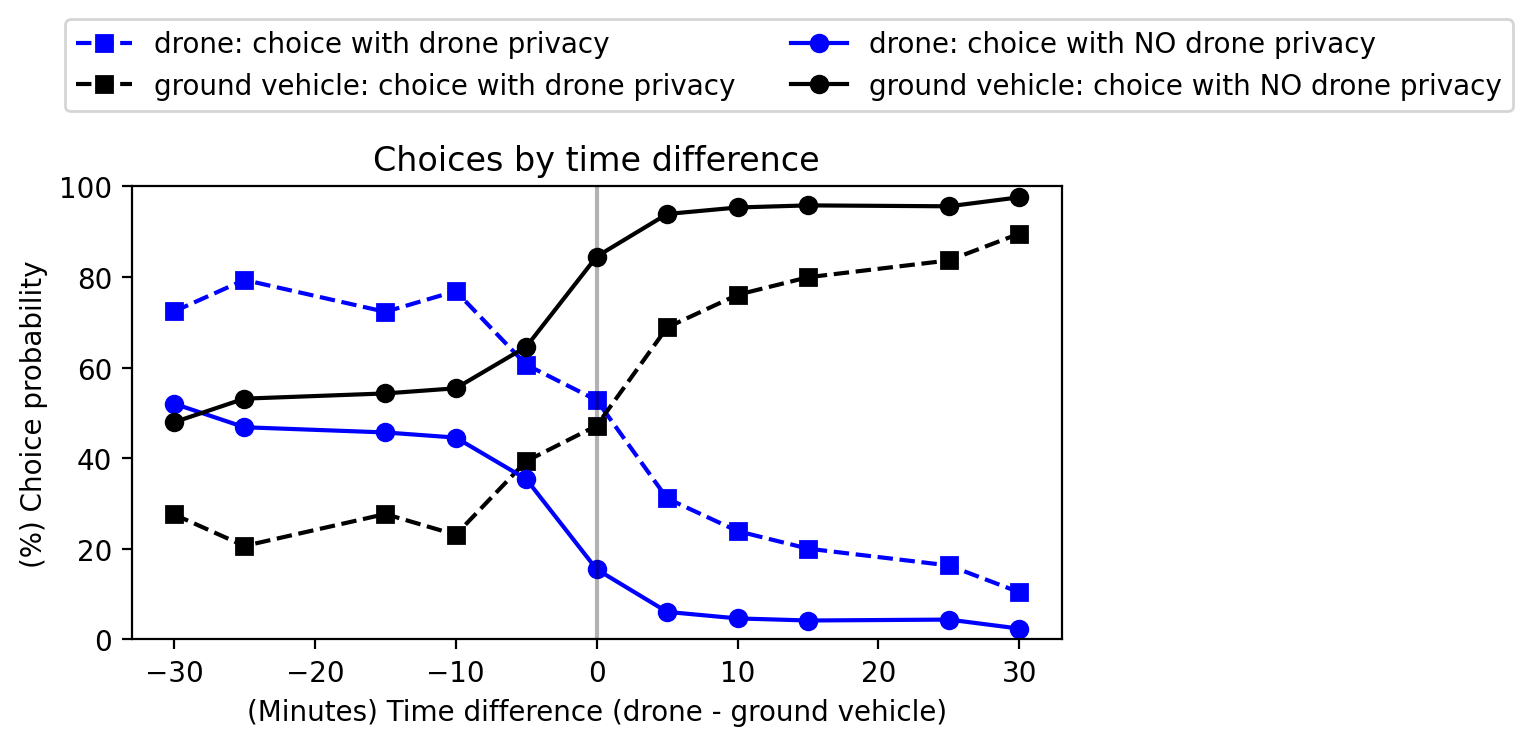

,count: YES privacy,% drone choice: YES privacy,% ground vehicle choice: YES privacy,count: NO privacy,% drone choice: NO privacy,% ground vehicle choice: NO privacy
d_time - g_time,,,,,,
-30,221,0.723982,0.276018,146,0.520548,0.479452
-25,567,0.793651,0.206349,301,0.468439,0.531561
-15,531,0.723164,0.276836,418,0.456938,0.543062
-10,251,0.768924,0.231076,487,0.445585,0.554415
-5,155,0.606452,0.393548,387,0.354005,0.645995
0,676,0.528107,0.471893,1267,0.154696,0.845304
5,151,0.311258,0.688742,329,0.060790,0.939210
10,230,0.239130,0.760870,323,0.046440,0.953560
15,888,0.200450,0.799550,550,0.041818,0.958182


In [23]:
fig,ax = plt.subplots(1,1, figsize=(6,3), dpi=200)
df = plot_choice_by_time_diff(
    time_diff_choices_df[time_diff_choices_df['v'].isin([0,2,3])], ax
)
# ax.legend(bbox_to_anchor=(0.5, 0.8))
ax.legend(ncol=2, bbox_to_anchor=(1.5, 1.4))
ax.set_xlabel('(Minutes) Time difference (drone - ground vehicle)')
ax.set_ylabel('(%) Choice probability') 
ax.set_title('Choices by time difference')
plt.show()
df

### Plot choice by cost difference and time difference together

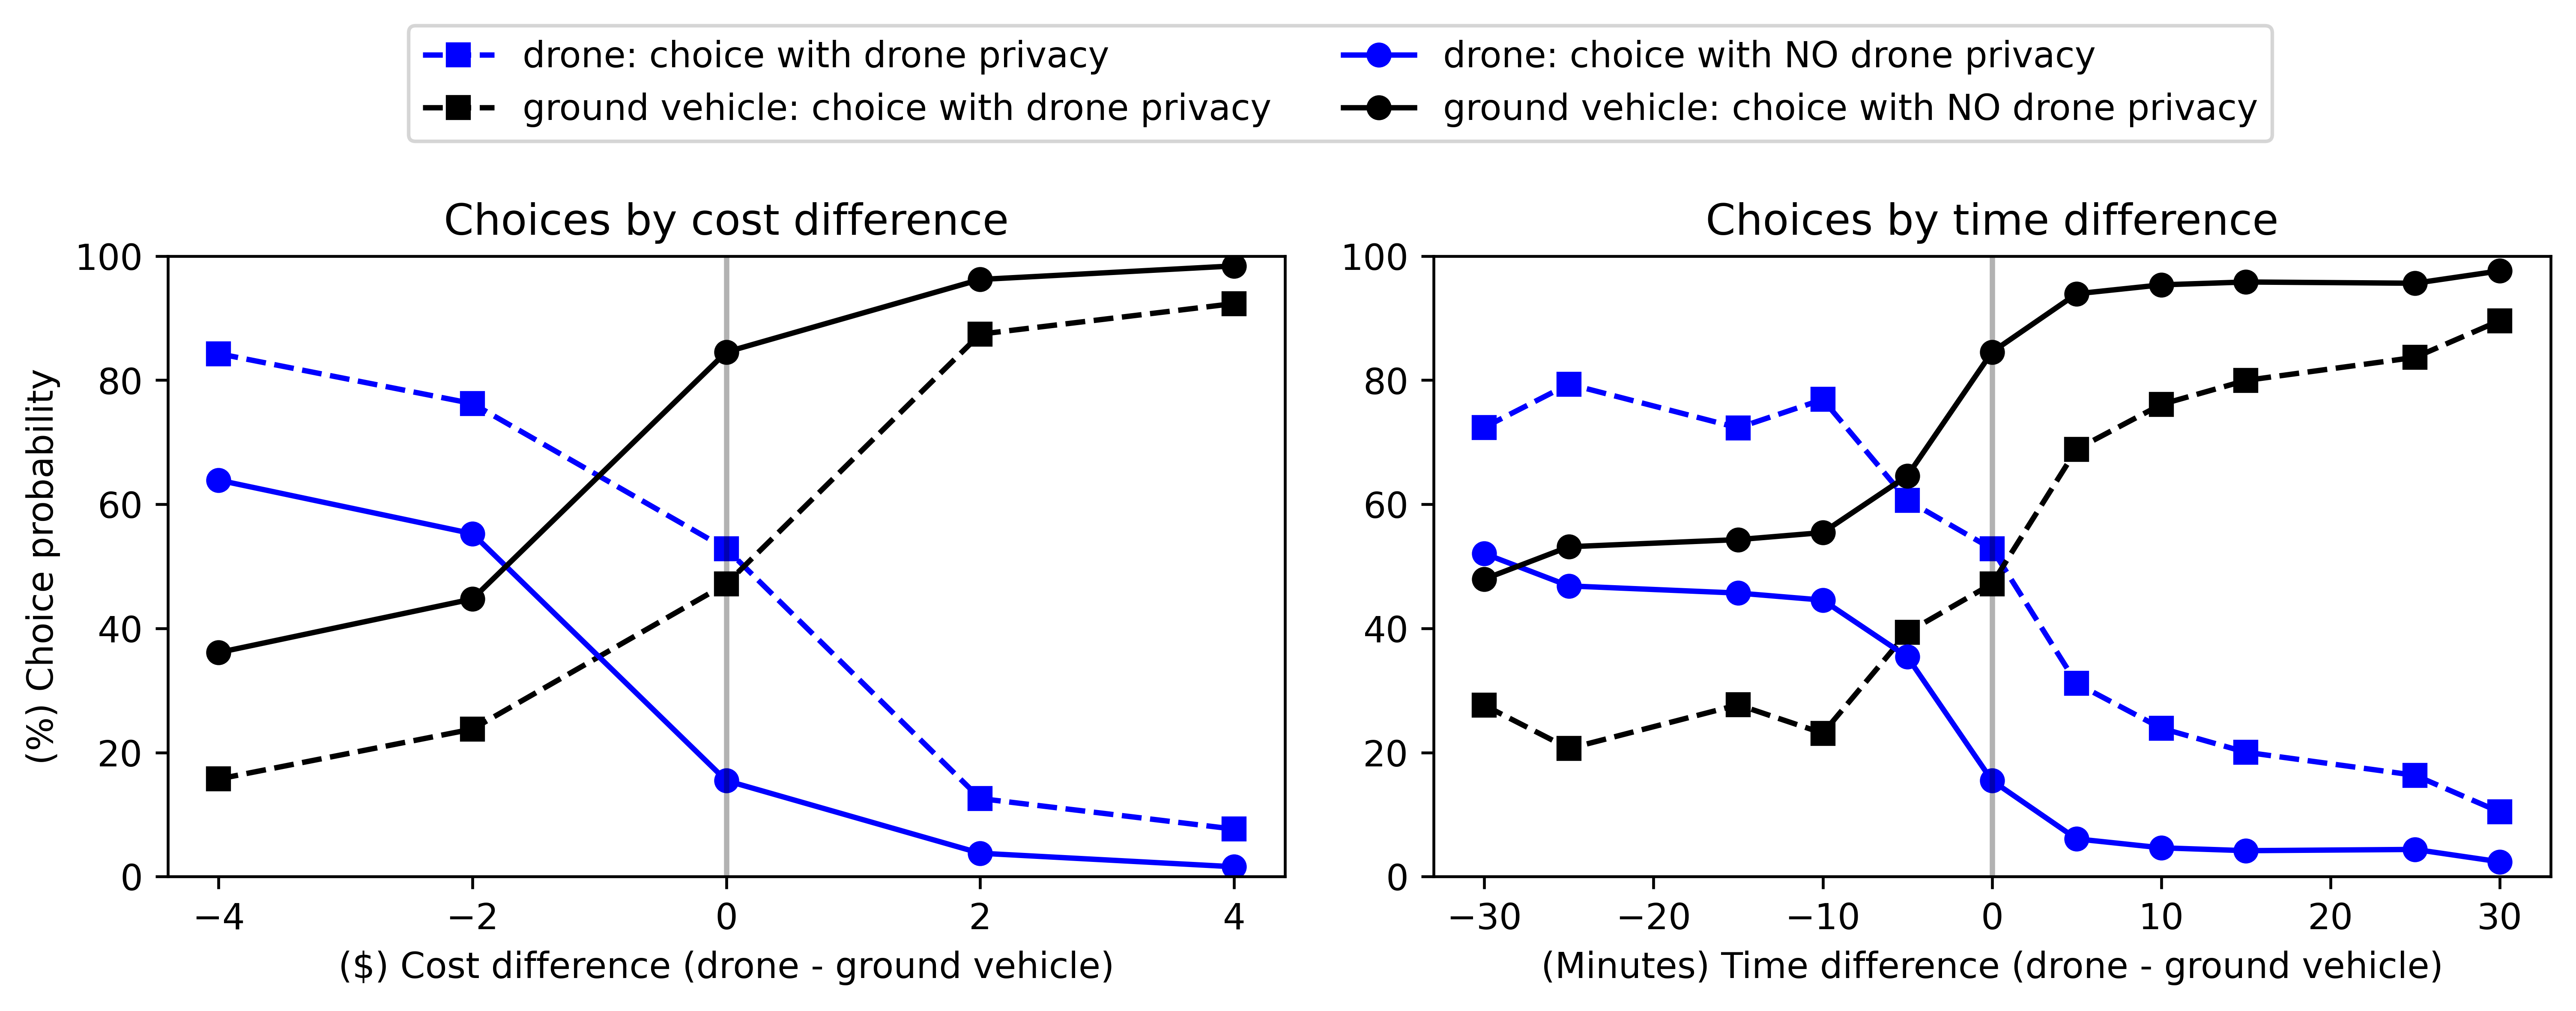

,count: YES privacy,% drone choice: YES privacy,% ground vehicle choice: YES privacy,count: NO privacy,% drone choice: NO privacy,% ground vehicle choice: NO privacy
d_cost - g_cost,,,,,,
-4,356,0.842697,0.157303,360,0.638889,0.361111
-2,673,0.762259,0.237741,532,0.552632,0.447368
0,676,0.528107,0.471893,1267,0.154696,0.845304
2,437,0.125858,0.874142,424,0.037736,0.962264
4,235,0.076596,0.923404,440,0.015909,0.984091


,count: YES privacy,% drone choice: YES privacy,% ground vehicle choice: YES privacy,count: NO privacy,% drone choice: NO privacy,% ground vehicle choice: NO privacy
d_time - g_time,,,,,,
-30,221,0.723982,0.276018,146,0.520548,0.479452
-25,567,0.793651,0.206349,301,0.468439,0.531561
-15,531,0.723164,0.276836,418,0.456938,0.543062
-10,251,0.768924,0.231076,487,0.445585,0.554415
-5,155,0.606452,0.393548,387,0.354005,0.645995
0,676,0.528107,0.471893,1267,0.154696,0.845304
5,151,0.311258,0.688742,329,0.060790,0.939210
10,230,0.239130,0.760870,323,0.046440,0.953560
15,888,0.200450,0.799550,550,0.041818,0.958182


In [167]:
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(10,3), dpi=600)
plt.tight_layout()
df1 = plot_choice_by_cost_diff(
    cost_diff_choices_df[cost_diff_choices_df['v'].isin([0,2,3])], ax1
)
ax1.legend(ncol=2, bbox_to_anchor=(1.9, 1.4))
ax1.set_xlabel('($) Cost difference (drone - ground vehicle)')
ax1.set_ylabel('(%) Choice probability') 
ax1.set_title('Choices by cost difference')

df2 = plot_choice_by_time_diff(
    time_diff_choices_df[time_diff_choices_df['v'].isin([0,2,3])], ax2
)
ax2.set_xlabel('(Minutes) Time difference (drone - ground vehicle)')
# ax2.set_ylabel('(%) Choice probability') 
ax2.set_title('Choices by time difference')
plt.show()
display(df1)
df2

## Choices by consumer group



In [168]:
cons_df = choices_df[[
    'choice',
    'dp',
    'male',
    'age_young', 'age_old',
    'income_lower', 'income_med', 'income_higher',
    'residence_house', 'residence_apartment', 
    'urban', 'suburban', 'rural', 
    'freq_ecommerce', 'freq_takeout_food', 
    'v', 'v_type'
]]
cons_df.head()

,choice,dp,male,age_young,age_old,income_lower,income_med,income_higher,residence_house,residence_apartment,urban,suburban,rural,freq_ecommerce,freq_takeout_food,v,v_type
0,1,0,1,1,0,0,0,1,0,1,1,0,0,0,1,2,liquor store
1,1,0,1,1,0,0,0,1,0,1,1,0,0,0,1,2,liquor store
2,0,0,1,1,0,0,0,1,0,1,1,0,0,0,1,0,take-out food
3,1,0,1,1,0,0,0,1,0,1,1,0,0,0,1,1,prescription medications
4,1,0,1,1,0,0,0,1,0,1,1,0,0,0,1,2,liquor store


In [169]:
def make_cons_plot_df(df):
    plot_df = df.groupby('dp')['choice'].agg(
        ['mean']
    ).rename(columns={'mean':'overall'})
    plot_df['male'] = df[df['male']==1].groupby('dp')['choice'].mean()
    #plot_df['non-male'] = df[df['male']==0].groupby('dp')['choice'].mean()
    col_labels = [
        ('age_young','age < 35'),
        ('age_old','age 55+'),
        #('income_lower','lower inc.'),
        #('income_med','medium inc.'),
        #('income_higher','higher inc.'),
        #('residence_house','house'),
        #('residence_apartment','apartment'),
        ('suburban','suburban'),
        ('urban','urban'),
        #('rural','rural'),
        ('freq_ecommerce','freq. ecommerce'),
        #('freq_takeout_food','freq. take-out'),
    ]

    for col, label in col_labels:
        plot_df[label] = df[df[col]==1].groupby('dp')['choice'].mean()

    # transpose and convert to % with x100
    plot_df = 100*plot_df.transpose().round(3)
    return plot_df

plot_df = make_cons_plot_df(cons_df)
plot_df

dp,0,1
overall,28.6,48.1
male,32.4,51.3
age < 35,29.3,51.7
age 55+,24.6,39.2
suburban,28.9,47.8
urban,27.5,48.3
freq. ecommerce,31.1,50.0


In [170]:
def plot_choices_by_consumer_group_bar(plot_df, ax, overall_lines=True, overall_bars=False):
    if overall_lines:
        # lines indicating overall
        ax.hlines(plot_df.loc['overall'][0], -1, 12,
                  colors=['gray'],linestyles='solid', label='overall: choice with NO drone privacy')
        ax.hlines(plot_df.loc['overall'][1], -1, 12,
                  colors=['black'],linestyles='solid', label='overall: choice with drone privacy')
    width = 0.4
    pdf = plot_df.drop(['overall']) if not overall_bars else plot_df
    (pdf[0]
     .plot(
        kind='bar', color='lightgray', edgecolor='black', #hatch='//',
        label='choice with NO drone privacy',
        ax=ax, width=width, position=1
    ))
    (pdf[1]
     .plot(
        kind='bar', color='black', 
        edgecolor='black', 
        label='choice with drone privacy',
        ax=ax, width=width, position=0)
    )
    ax.set_ylabel('(%) Drone choice')
    ax.set_xlim([-0.5,5.5])
    ax.set_ylim([0,59])
    ax.set_xticklabels(pdf.index, rotation=0)

drone preference by consumer group:


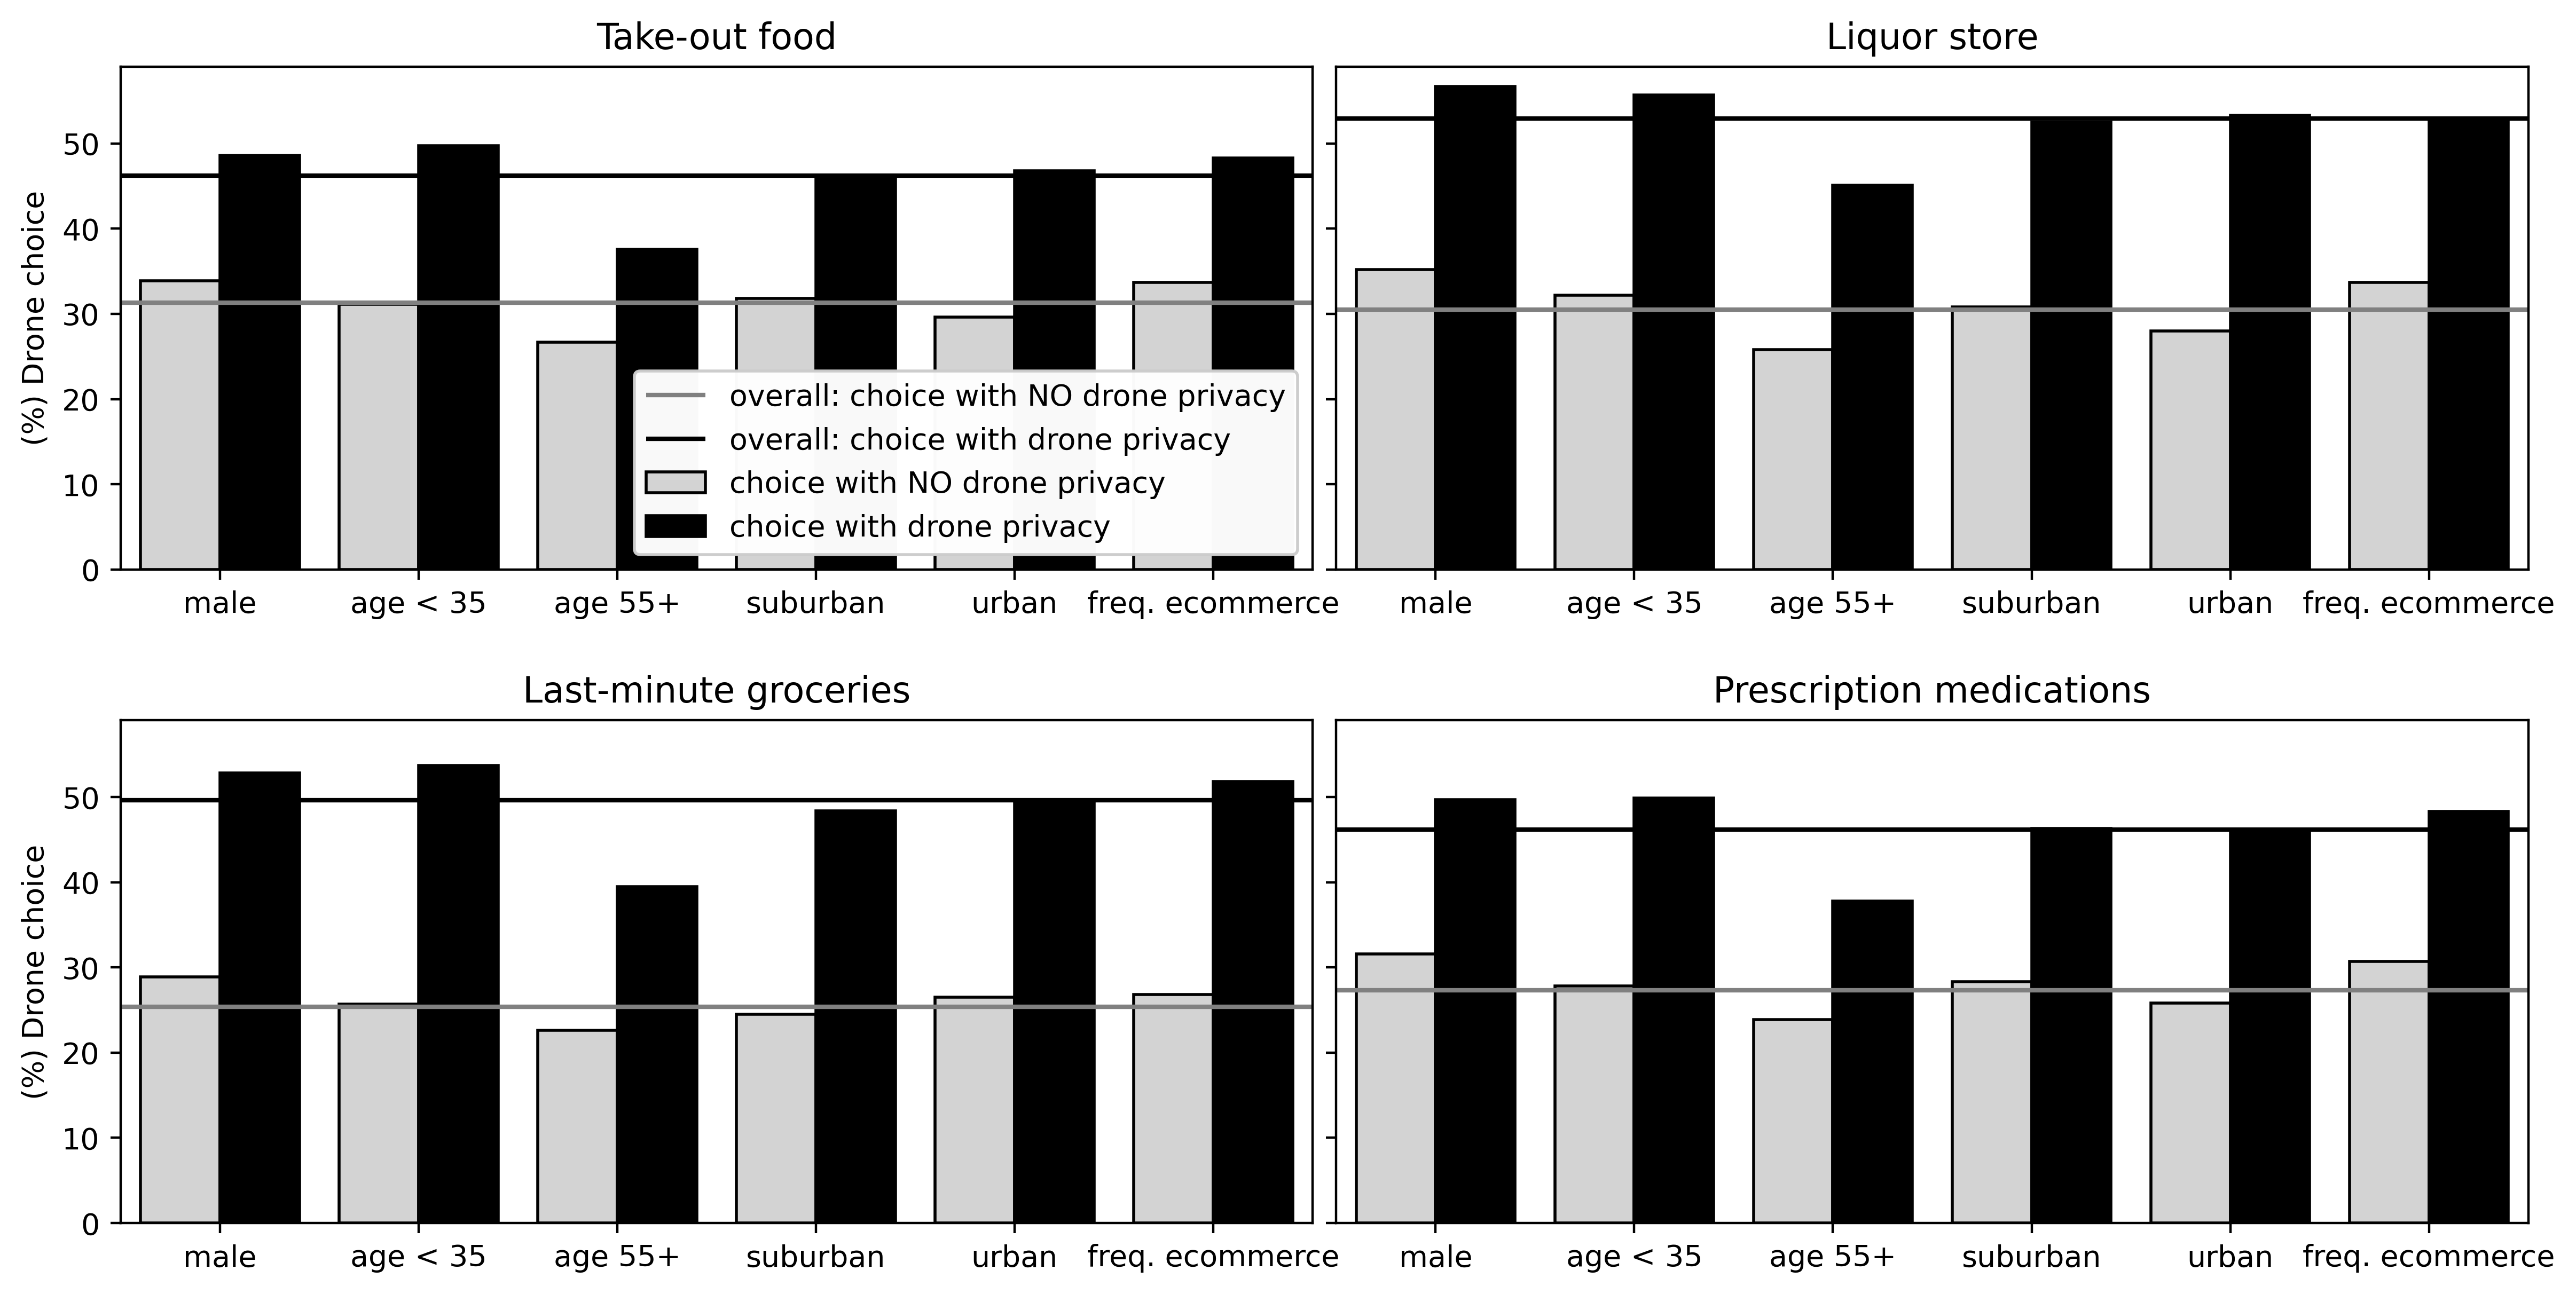

In [171]:
print('drone preference by consumer group:')
# fig,axes = plt.subplots(4,1,figsize=(11,16),dpi=150)
# plt.subplots_adjust(hspace=0.3)

fig, axes = plt.subplots(2,2, figsize=(12,6),dpi=400,sharey=True)
plt.tight_layout()
plt.subplots_adjust(wspace=0.02, hspace=0.3)
plots_order_vs = [0,2,3,1] # determines plot order
for i, v in enumerate(plots_order_vs):
    ax = axes.flat[i]
    v_type = VENDOR_TYPES[v][0]
    v_plot_df = make_cons_plot_df(cons_df[cons_df['v']==v])
    ax.set_title('%s' % v_type.capitalize())
    plot_choices_by_consumer_group_bar(v_plot_df, ax)
    if v==0:
        ax.legend(facecolor='white', framealpha=0.98, loc='lower right')#bbox_to_anchor=(0.72, 1.04))
    #display(v_plot_df)

Text(0.5, 1.0, 'drone preference by consumer group: over all vendors')

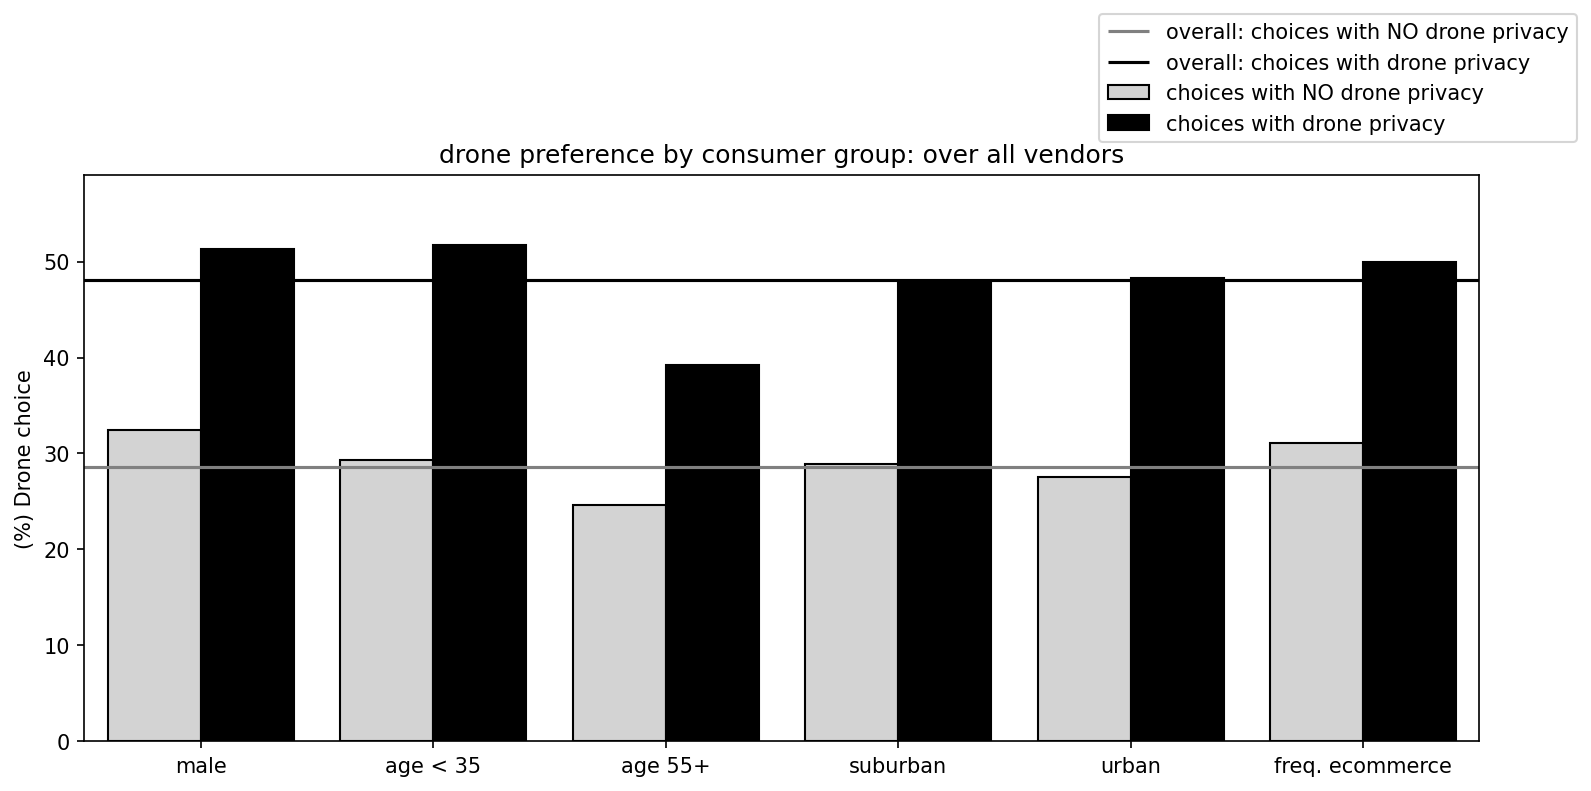

In [29]:
fig,ax = plt.subplots(1,1,figsize=(12,5), dpi=150)
plot_choices_by_consumer_group_bar(make_cons_plot_df(cons_df), ax)
ax.legend(bbox_to_anchor=(0.72, 1.04))
ax.set_title('drone preference by consumer group: over all vendors')

### Plots showing delivery preference by consumer group

These plots represent the number of times drone was chosen over ground vehicle for delivery, counted across all choice sets, regardless of time or cost differences.

The plots show the differences in choices between consumer groups. Note that different consumers and hence consumer groups saw different choices, and these plots do not account for those differences. The estimated model coefficients do.

Freq. e-commerce represents consumers who answered "more than once per week" to question: "How often (on average) do you make online shopping purchases?"

- What is a better way to show these plots?
- Many of the consumer group coefficients are not significant in the model results. Should these be removed from the plots? e.g. consider plots that only show male, non-male, age groups, freq. e-commerce.

In [39]:
# in case we prefer horizontal bar plots

def plot_choices_by_consumer_group_barh(plot_df, ax, overall_lines=True, overall_bars=False):
    if overall_lines:
        # lines indicating overall
        ax.axvline(
            plot_df.loc['overall'][0],
            color='gray',linestyle='-', label='overall NO drone privacy'
        )
        ax.axvline(
            plot_df.loc['overall'][1],
            color='black',linestyle='-', label='overall YES drone privacy'
        )
    width = 0.4
    pdf = plot_df.drop(['overall']) if not overall_bars else plot_df
    (pdf[0]
     .plot(
        kind='barh', color='lightgray', edgecolor='black', #hatch='//',
        label='NO drone privacy',
        ax=ax, width=width, position=1
    ))
    (pdf[1]
     .plot(
        kind='barh', color='black', 
        edgecolor='black', 
        label='YES drone privacy',
        ax=ax, width=width, position=0)
    )
    ax.set_xlabel('(%) drone choice')
    ax.set_xlim([-0,100])
    plt.xticks(rotation=0)

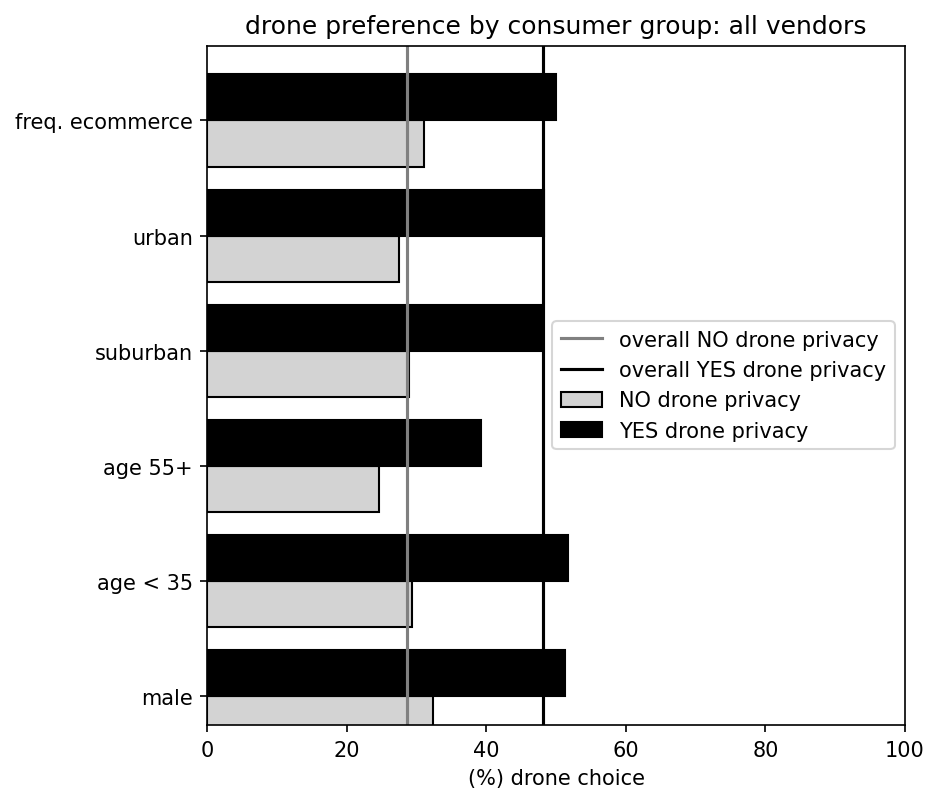

In [40]:
fig,ax = plt.subplots(1,1,figsize=(6,6), dpi=150)
plot_choices_by_consumer_group_barh(make_cons_plot_df(cons_df), ax)
ax.legend()
ax.set_title('drone preference by consumer group: all vendors')
plt.show()